## Libraries

In [1]:
import abc
import codecs
import inspect
import json
import logging
import gc
import os
import pickle
import random
import sys
import time
import warnings

import catboost as cat
import category_encoders as ce
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torchdata
import yaml

from abc import abstractmethod
from collections import Counter
from contextlib import contextmanager
from pathlib import Path
from typing import List, Optional, Union, Tuple, Dict, Sequence, Set

from catboost import CatBoostClassifier, CatBoostRegressor
from fastprogress import progress_bar
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.multiclass import unique_labels
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm_notebook

Using TensorFlow backend.


## Config

In [2]:
conf_string = '''
dataset:
  dir: "../input/data-science-bowl-2019/"
  feature_dir: "features"
  params:

features:
  - PastSummary3
  - NakamaV8

av:
  split_params:
    n_splits: 5
    random_state: 42

  model_params:
    objective: "binary"
    metric: "auc"
    boosting: "gbdt"
    max_depth: 7
    num_leaves: 75
    learning_rate: 0.01
    colsample_bytree: 0.7
    subsample: 0.1
    subsample_freq: 1
    seed: 111
    feature_fraction_seed: 111
    drop_seed: 111
    verbose: -1
    n_jobs: -1
    first_metric_only: True

  train_params:
    num_boost_round: 50000
    early_stopping_rounds: 200
    verbose_eval: 200

model:
  name: "mlp"
  mode: "ovr"
  save_path: "pth/"
  policy: "best_score"

  model_params:
    emb_drop: 0.3
    drop: 0.5

  train_params:
    batch_size: 256
    n_epochs: 50
    lr: 0.001
    scheduler:
      name: "cosine"
      T_max: 10
      eta_min: 0.00001

post_process:
  params:
    reverse: False
    n_overall: 20
    n_classwise: 20

val:
  name: "group_kfold"
  n_delete: 0.9
  percentile: 60
  params:
    n_splits: 5
    random_state: 111

output_dir: "output"
'''

In [3]:
config = dict(yaml.load(conf_string, Loader=yaml.SafeLoader))

In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
    
seed_everything(42)

## Functions and Classes

### utils

#### checker

In [5]:
def feature_existence_checker(feature_path: Path,
                              feature_names: List[str]) -> bool:
    features = [f.name for f in feature_path.glob("*.ftr")]
    for f in feature_names:
        if f + "_train.ftr" not in features:
            return False
        if f + "_valid.ftr" not in features:
            return False
        if f + "_test.ftr" not in features:
            return False
    return True

#### jsonutil

In [6]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def save_json(config: dict, save_path: Union[str, Path]):
    f = codecs.open(str(save_path), mode="w", encoding="utf-8")
    json.dump(config, f, indent=4, cls=MyEncoder, ensure_ascii=False)
    f.close()

#### logger

In [7]:
def configure_logger(config_name: str, log_dir: Union[Path, str], debug: bool):
    if isinstance(log_dir, str):
        Path(log_dir).mkdir(parents=True, exist_ok=True)
    else:
        log_dir.mkdir(parents=True, exist_ok=True)

    log_filename = config_name.split("/")[-1].replace(".yml", ".log")
    log_filepath = log_dir / log_filename \
        if isinstance(log_dir, Path) else Path(log_dir) / log_filename

    # delete the old log
    if log_filepath.exists():
        with open(log_filepath, mode="w"):
            pass

    level = logging.DEBUG if debug else logging.INFO
    logging.basicConfig(
        filename=str(log_filepath),
        level=level,
        format="%(asctime)s %(levelname)s %(message)s",
        datefmt="%m/%d/%Y %I:%M:%S %p")

#### timer

In [8]:
@contextmanager
def timer(name: str, log: bool = False):
    t0 = time.time()
    msg = f"[{name}] start"
    if not log:
        print(msg)
    else:
        logging.info(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    if not log:
        print(msg)
    else:
        logging.info(msg)

#### visualization

In [9]:
def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          save_path: Path = Path("./")):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, fontsize=25)
    plt.yticks(tick_marks, fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)
    plt.ylabel('True label', fontsize=25)
    plt.title(title, fontsize=30)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size="5%", pad=0.15)
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=20)

    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        #            title=title,
        ylabel='True label',
        xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                fontsize=20,
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(save_path)

#### tools

In [10]:
def reduce_mem_usage(df: pd.DataFrame,
                     verbose: bool = True,
                     debug: bool = True) -> pd.DataFrame:
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == "int":
                if (c_min > np.iinfo(np.int8).min
                        and c_max < np.iinfo(np.int8).max):
                    df[col] = df[col].astype(np.int8)
                elif (c_min > np.iinfo(np.int16).min
                      and c_max < np.iinfo(np.int16).max):
                    df[col] = df[col].astype(np.int16)
                elif (c_min > np.iinfo(np.int32).min
                      and c_max < np.iinfo(np.int32).max):
                    df[col] = df[col].astype(np.int32)
                elif (c_min > np.iinfo(np.int64).min
                      and c_max < np.iinfo(np.int64).max):
                    df[col] = df[col].astype(np.int64)
            else:
                if (c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max):
                    df[col] = df[col].astype(np.float16)
                elif (c_min > np.finfo(np.float32).min
                      and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    reduction = (start_mem - end_mem) / start_mem

    msg = f"Mem. usage decreased to {end_mem:5.2f} MB" + \
        f" ({reduction * 100:.1f} % reduction)"
    if verbose:
        print(msg)

    if debug:
        logging.debug(msg)

    return df

#### duplicate

In [11]:
def delete_duplicated_columns(df: pd.DataFrame):
    df = df.loc[:, ~df.columns.duplicated()]
    return df

### validation

In [12]:
def group_kfold(df: pd.DataFrame, groups: pd.Series,
                config: dict) -> List[Tuple[np.ndarray, np.ndarray]]:
    params = config["val"]["params"]
    kf = KFold(
        n_splits=params["n_splits"],
        random_state=params["random_state"],
        shuffle=True)
    uniq_groups = groups.unique()
    split = []
    for trn_grp_idx, val_grp_idx in kf.split(uniq_groups):
        trn_grp = uniq_groups[trn_grp_idx]
        val_grp = uniq_groups[val_grp_idx]
        trn_idx = df[df["group"].isin(trn_grp)].index.values
        val_idx = df[df["group"].isin(val_grp)].index.values
        split.append((trn_idx, val_idx))

    return split


def get_validation(df: pd.DataFrame,
                   config: dict) -> List[Tuple[np.ndarray, np.ndarray]]:
    name: str = config["val"]["name"]

    func = globals().get(name)
    if func is None:
        raise NotImplementedError

    if "group" in name:
        groups = df["group"]
        return func(df, groups, config)
    else:
        return func(df, config)

#### feature_selection

In [13]:
def select_features(cols: List[str],
                    feature_importance: pd.DataFrame,
                    config: dict,
                    delete_higher_importance: bool = False) -> List[str]:
    if config["val"].get("n_delete") is None:
        return cols

    n_delete = config["val"].get("n_delete")
    importance_sorted_cols = feature_importance.sort_values(
        by="value",
        ascending=not (delete_higher_importance))["feature"].tolist()
    if isinstance(n_delete, int):
        remove_cols = importance_sorted_cols[:n_delete]
        cols = [col for col in cols if col not in remove_cols]
    elif isinstance(n_delete, float):
        n_delete_int = int(n_delete * len(importance_sorted_cols))
        remove_cols = importance_sorted_cols[:n_delete_int]
        cols = [col for col in cols if col not in remove_cols]
    return cols


def remove_correlated_features(df: pd.DataFrame, features: List[str]):
    counter = 0
    to_remove: List[str] = []
    for i in tqdm_notebook(range(len(features) - 1)):
        feat_a = features[i]
        for j in range(i + 1, len(features)):
            feat_b = features[j]
            if feat_a in to_remove or feat_b in to_remove:
                continue
            c = np.corrcoef(df[feat_a], df[feat_b])[0][1]
            if c > 0.995:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(
                    counter, feat_a, feat_b, c))
    return to_remove

#### nth_assessment

In [14]:
def get_assessment_number(valid_df: pd.DataFrame, test_df: pd.DataFrame):
    valid_nth_assessment: List[int] = []
    for _, sample in valid_df.groupby("installation_id"):
        valid_nth_assessment.extend(np.arange(len(sample)) + 1)

    valid_df_ = valid_df.copy()
    valid_df_["nth_assessment"] = valid_nth_assessment

    test_nth_assessment = []
    for inst_id in test_df["installation_id"].values:
        if inst_id in valid_df_["installation_id"].values:
            test_nth_assessment.append(
                valid_df_.query(f"installation_id == '{inst_id}'")
                ["nth_assessment"].max() + 1)
        else:
            test_nth_assessment.append(1)
    return np.array(test_nth_assessment)

### sampling

#### factory

In [15]:
def smote(x_trn: np.ndarray, y_trn: np.ndarray,
          config: dict) -> Tuple[np.ndarray, np.ndarray]:
    params = config["model"]["sampling"]["params"]
    sm = SMOTE(
        k_neighbors=params["k_neighbors"], random_state=params["random_state"])
    sampled_x, sampled_y = sm.fit_resample(x_trn, y_trn)
    return sampled_x, sampled_y


def random_under_sample(x_trn: np.ndarray, y_trn: np.ndarray,
                        config: dict) -> Tuple[np.ndarray, np.ndarray]:
    params = config["model"]["sampling"]["params"]
    acc_0 = (y_trn == 0).sum().astype(int)
    acc_1 = (y_trn == 1).sum().astype(int)
    acc_2 = (y_trn == 2).sum().astype(int)
    acc_3 = (y_trn == 3).sum().astype(int)
    rus = RandomUnderSampler({
        0: int(params["acc_0_coef"] * acc_0),
        1: int(params["acc_1_coef"] * acc_1),
        2: int(params["acc_2_coef"] * acc_2),
        3: int(params["acc_3_coef"] * acc_3)
    },
                             random_state=params["random_state"])
    sampled_x, sampled_y = rus.fit_resample(x_trn, y_trn)
    return sampled_x, sampled_y


def random_under_sample_and_smote(
        x_trn: np.ndarray, y_trn: np.ndarray,
        config: dict) -> Tuple[np.ndarray, np.ndarray]:
    sampled_x, sampled_y = random_under_sample(x_trn, y_trn, config)
    sampled_x, sampled_y = smote(sampled_x, sampled_y, config)
    return sampled_x, sampled_y


def get_sampling(x_trn: np.ndarray, y_trn: np.ndarray,
                 config: dict) -> Tuple[np.ndarray, np.ndarray]:
    if config["model"]["sampling"]["name"] == "none":
        return x_trn, y_trn

    policy = config["model"]["sampling"]["name"]
    func = globals().get(policy)
    if func is None:
        raise NotImplementedError
    return func(x_trn, y_trn, config)

### evaluation

#### metrics

In [16]:
def qwk(y_true: Union[np.ndarray, list],
        y_pred: Union[np.ndarray, list],
        max_rat: int = 3) -> float:
    y_true_ = np.asarray(y_true)
    y_pred_ = np.asarray(y_pred)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    uniq_class = np.unique(y_true_)
    for i in uniq_class:
        hist1[int(i)] = len(np.argwhere(y_true_ == i))
        hist2[int(i)] = len(np.argwhere(y_pred_ == i))

    numerator = np.square(y_true_ - y_pred_).sum()

    denominator = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            denominator += hist1[i] * hist2[j] * (i - j) * (i - j)

    denominator /= y_true_.shape[0]
    return 1 - numerator / denominator


def calc_metric(y_true: Union[np.ndarray, list],
                y_pred: Union[np.ndarray, list]) -> float:
    return qwk(y_true, y_pred)

#### optimization

In [17]:
class OptimizedRounder(object):
    def __init__(self,
                 n_overall: int = 5,
                 n_classwise: int = 5,
                 reverse: bool = False):
        self.n_overall = n_overall
        self.n_classwise = n_classwise
        self.coef = [0.25, 0.5, 0.75]
        self.reverse = reverse

    def _loss(self, X: np.ndarray, y: np.ndarray) -> float:
        X_p = np.digitize(X, self.coef)
        ll = -calc_metric(y, X_p)
        return ll

    def fit(self, X: np.ndarray, y: np.ndarray):
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(0.01, 0.5), (0.5, 0.7), (0.7, 0.9)]
        for _ in range(self.n_overall):
            if self.reverse:
                search = reversed(range(3))
            else:
                search = iter(range(3))
            for idx in search:
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                self.coef[idx] = a
                la = self._loss(X, y)
                self.coef[idx] = b
                lb = self._loss(X, y)
                for it in range(self.n_classwise):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        self.coef[idx] = a
                        la = self._loss(X, y)
                    else:
                        b = b - (b - a) * golden2
                        self.coef[idx] = b
                        lb = self._loss(X, y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        X_p = np.digitize(X, self.coef)
        return X_p
    
    
class GroupWiseOptimizer(object):
    def __init__(self, n_overall: int = 5, n_classwise: int = 5):
        self.n_overall = n_overall
        self.n_classwise = n_classwise

    def fit(self, X: np.ndarray, y: np.ndarray, group: np.ndarray):
        self.rounders = {
            gp: OptimizedRounder(
                n_overall=self.n_overall, n_classwise=self.n_classwise)
            for gp in np.unique(group)
        }
        for gp in self.rounders.keys():
            X_gp = X[group == gp]
            y_gp = y[group == gp]
            self.rounders[gp].fit(X_gp, y_gp)

    def predict(self, X: np.ndarray, group: np.ndarray) -> np.ndarray:
        result = np.zeros_like(X)
        for gp in self.rounders.keys():
            X_gp = X[group == gp]
            result[group == gp] = self.rounders[gp].predict(X_gp)
        return result

#### cat

In [18]:
class CatBoostOptimizedQWKMetric(object):
    def __init__(self,
                 n_overall: int = 5,
                 n_classwise: int = 5,
                 reverse: bool = False):
        self.n_overall = n_overall
        self.n_classwise = n_classwise
        self.reverse = reverse

    def get_final_error(self, error: float, weight: float) -> float:
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target,
                 weight: Optional[Sequence[float]]) -> Tuple[float, float]:
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]
        approx_np = np.array(approx)
        target_np = (np.array(target) * 3).astype(int)

        OptR = OptimizedRounder(
            n_classwise=self.n_classwise,
            n_overall=self.n_overall,
            reverse=self.reverse)
        OptR.fit(approx_np, target_np)

        y_pred = OptR.predict(approx_np).astype(int)
        y_true = target_np.astype(int)

        weight_sum = 1.0
        qwk = calc_metric(y_true, y_pred)
        return qwk, weight_sum
    
    
class CatBoostMulticlassOptimizedQWK(object):
    def __init__(self,
                 n_overall: int = 5,
                 n_classwise: int = 5,
                 reverse: bool = False):
        self.n_overall = n_overall
        self.n_classwise = n_classwise
        self.reverse = reverse

    def get_final_error(self, error: float, weight: float) -> float:
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target,
                 weight: Optional[Sequence[float]]) -> Tuple[float, float]:
        approx_np = np.array(approxes)
        target_np = np.array(target)

        exponent = np.exp(approx_np)
        softmax = exponent / np.sum(exponent, axis=0)
        y_pred = np.arange(4) @ softmax / 3

        OptR = OptimizedRounder(
            n_classwise=self.n_classwise,
            n_overall=self.n_overall,
            reverse=self.reverse)
        OptR.fit(y_pred, target_np)

        y_pred = OptR.predict(y_pred).astype(int)
        y_true = target_np.astype(int)

        weight_sum = 1.0
        qwk = calc_metric(y_true, y_pred)
        return qwk, weight_sum

#### lgbm

In [19]:
def lgb_classification_qwk(y_pred: np.ndarray,
                           data: lgb.Dataset) -> Tuple[str, float, bool]:
    y_true = data.get_label()
    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return "qwk", calc_metric(y_true, y_pred), True


def lgb_regression_qwk(y_pred: np.ndarray,
                       data: lgb.Dataset) -> Tuple[str, float, bool]:
    y_true = (data.get_label() * 3).astype(int)
    y_pred = y_pred.reshape(-1)

    OptR = OptimizedRounder(n_classwise=3, n_overall=3)
    OptR.fit(y_pred, y_true)

    y_pred = OptR.predict(y_pred).astype(int)
    qwk = calc_metric(y_true, y_pred)

    return "qwk", qwk, True


def lgb_multiclass_qwk(y_pred: np.ndarray,
                       data: lgb.Dataset) -> Tuple[str, float, bool]:
    y_true = data.get_label()
    y_pred = y_pred.reshape(len(np.unique(y_true)), -1)
    y_pred_regr = np.arange(4) @ y_pred / 3

    OptR = OptimizedRounder(n_classwise=3, n_overall=3)
    OptR.fit(y_pred_regr, y_true)

    y_pred = OptR.predict(y_pred_regr).astype(int)
    return "qwk", calc_metric(y_true, y_pred), True


def lgb_residual_qwk_closure(mean_target: np.ndarray):
    def lgb_residual_qwk(y_pred: np.ndarray,
                         data: lgb.Dataset) -> Tuple[str, float, bool]:
        y_true = (data.get_label() * 3).astype(int)
        y_pred = y_pred.reshape(-1)

        y_true = (y_true + mean_target).astype(int)
        y_pred = y_pred + mean_target

        OptR = OptimizedRounder(n_classwise=5, n_overall=5)
        OptR.fit(y_pred, y_true)

        y_pred = OptR.predict(y_pred).astype(int)
        qwk = calc_metric(y_true, y_pred)

        return "qwk", qwk, True

    return lgb_residual_qwk

#### truncate

In [20]:
def eval_with_truncated_data(
        y_pred: np.ndarray,
        y_true: np.ndarray,
        groups: np.ndarray,
        n_trials: int = 10) -> Dict[str, Union[List[float], float]]:
    eval_result: Dict[str, Union[List[float], float]] = {}
    trials: List[float] = []

    index = np.arange(len(y_pred))
    gp_idx_df = pd.DataFrame({"groups": groups, "index": index})
    dice_results = []
    for _, df in gp_idx_df.groupby("groups"):
        dice_result = np.random.choice(df["index"], size=n_trials)
        dice_results.append(dice_result)

    idx_choice = np.vstack(dice_results)
    for i in range(n_trials):
        y_pred_choice = y_pred[idx_choice[:, i]]
        y_true_choice = y_true[idx_choice[:, i]]
        trials.append(calc_metric(y_true_choice, y_pred_choice))

    mean_score = np.mean(trials)
    median_score = np.median(trials)
    std = np.std(trials)
    eval_result["mean"] = mean_score
    eval_result["median"] = median_score
    eval_result["all_trials"] = trials
    eval_result["0.95lower_bound"] = mean_score - 2 * std
    eval_result["0.95upper_bound"] = mean_score + 2 * std
    eval_result["std"] = std
    return eval_result

### models

#### base

In [21]:
# type alias
AoD = Union[np.ndarray, pd.DataFrame]
AoS = Union[np.ndarray, pd.Series]
CatModel = Union[cat.CatBoostClassifier, cat.CatBoostRegressor]
LGBModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]
Model = Union[CatModel, LGBModel]


class BaseModel(object):
    @abstractmethod
    def fit(self, x_train: AoD, y_train: AoS, x_valid: AoD, y_valid: AoS,
            x_valid2: Optional[AoD], y_valid2: Optional[AoS],
            config: dict) -> Tuple[Model, dict]:
        raise NotImplementedError

    @abstractmethod
    def get_best_iteration(self, model: Model) -> int:
        raise NotImplementedError

    @abstractmethod
    def predict(self, model: Model, features: AoD) -> np.ndarray:
        raise NotImplementedError

    @abstractmethod
    def get_feature_importance(self, model: Model) -> np.ndarray:
        raise NotImplementedError

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     valid_preds: Optional[np.ndarray], y: np.ndarray,
                     y_valid: Optional[np.ndarray], config: dict
                     ) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray]]:
        return oof_preds, test_preds, valid_preds

    def cv(self,
           y_train: AoS,
           train_features: AoD,
           test_features: AoD,
           y_valid: Optional[AoS],
           valid_features: Optional[AoD],
           feature_name: List[str],
           folds_ids: List[Tuple[np.ndarray, np.ndarray]],
           config: dict,
           log: bool = True
           ) -> Tuple[List[Model], np.ndarray, np.
                      ndarray, Optional[np.ndarray], pd.DataFrame, dict]:
        # initialize
        test_preds = np.zeros(len(test_features))
        oof_preds = np.zeros(len(train_features))
        if valid_features is not None:
            valid_preds = np.zeros(len(valid_features))
        else:
            valid_preds = None
        importances = pd.DataFrame(index=feature_name)
        best_iteration = 0.0
        cv_score_list: List[dict] = []
        models: List[Model] = []

        if config["model"]["mode"] == "residual":
            self.mean_targets: Dict[str, List[np.ndarray]] = {
                "train": [],
                "valid": [],
                "valid2": [valid_features["mean_target"].values],
                "test": [test_features["mean_target"].values]
            }
            valid_features.drop("mean_target", axis=1, inplace=True)
            test_features.drop("mean_target", axis=1, inplace=True)
            for t_idx, v_idx in folds_ids:
                self.mean_targets["train"].append(
                    train_features.loc[t_idx, "mean_target"].values)
                self.mean_targets["valid"].append(
                    train_features.loc[v_idx, "mean_target"].values)
            train_features.drop("mean_target", axis=1, inplace=True)
            feature_name.remove("mean_target")

        X = train_features.values if isinstance(train_features, pd.DataFrame) \
            else train_features
        y = y_train.values if isinstance(y_train, pd.Series) \
            else y_train

        X_valid = valid_features.values if isinstance(
            valid_features, pd.DataFrame) else valid_features
        y_valid = y_valid.values if isinstance(y_valid, pd.Series) \
            else y_valid

        for i_fold, (trn_idx, val_idx) in enumerate(folds_ids):
            self.fold = i_fold
            # get train data and valid data
            x_trn = X[trn_idx]
            y_trn = y[trn_idx]
            x_val = X[val_idx]
            y_val = y[val_idx]

            # train model
            model, best_score = self.fit(
                x_trn, y_trn, x_val, y_val, X_valid, y_valid, config=config)
            cv_score_list.append(best_score)
            models.append(model)
            best_iteration += self.get_best_iteration(model) / len(folds_ids)

            # predict oof and test
            oof_preds[val_idx] = self.predict(model, x_val).reshape(-1)
            test_preds += self.predict(
                model, test_features).reshape(-1) / len(folds_ids)

            if valid_features is not None:
                valid_preds += self.predict(
                    model, valid_features).reshape(-1) / len(folds_ids)

            if config["model"]["mode"] == "residual":
                oof_preds[val_idx] += self.mean_targets["valid"][self.fold]
                test_preds += self.mean_targets["test"][0]
                valid_preds += self.mean_targets["valid2"][0]

            # get feature importances
            importances_tmp = pd.DataFrame(
                self.get_feature_importance(model),
                columns=[f"gain_{i_fold+1}"],
                index=feature_name)
            importances = importances.join(importances_tmp, how="inner")

        # summary of feature importance
        feature_importance = importances.mean(axis=1)

        # save raw prediction
        self.raw_oof_preds = oof_preds
        self.raw_test_preds = test_preds
        self.raw_valid_preds = valid_preds

        # post_process (if you have any)
        oof_preds, test_preds, valid_preds = self.post_process(
            oof_preds, test_preds, valid_preds, y_train, y_valid, config)

        # print oof score
        oof_score = calc_metric(y_train, oof_preds)
        print(f"oof score: {oof_score:.5f}")
        if valid_features is not None:
            valid_score = calc_metric(y_valid, valid_preds)
            print(f"valid score: {valid_score:.5f}")

        if log:
            logging.info(f"oof score: {oof_score:.5f}")
            if valid_features is not None:
                logging.info(f"valid score: {valid_score:.5f}")

        evals_results = {
            "evals_result": {
                "oof_score":
                oof_score,
                "cv_score": {
                    f"cv{i + 1}": cv_score
                    for i, cv_score in enumerate(cv_score_list)
                },
                "n_data":
                len(train_features),
                "best_iteration":
                best_iteration,
                "n_features":
                len(train_features.columns),
                "feature_importance":
                feature_importance.sort_values(ascending=False).to_dict()
            }
        }

        if valid_features is not None:
            evals_results["valid_score"] = valid_score
        return (models, oof_preds, test_preds, valid_preds, feature_importance,
                evals_results)

#### classwise

In [22]:
# type alias
AoD = Union[np.ndarray, pd.DataFrame]
AoS = Union[np.ndarray, pd.Series]
CatModel = Union[cat.CatBoostClassifier, cat.CatBoostRegressor]
LGBModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]
Model = Union[CatModel, LGBModel]


class ClassWiseBase(object):
    @abstractmethod
    def fit(self, x_train: AoD, y_train: AoS,
            valid_sets: List[Tuple[AoD, AoS]],
            config: dict) -> Tuple[Model, dict]:
        raise NotImplementedError

    @abstractmethod
    def get_best_iteration(self, model: Model) -> int:
        raise NotImplementedError

    @abstractmethod
    def predict(self, model: Model, features: AoD) -> np.ndarray:
        raise NotImplementedError

    @abstractmethod
    def get_feature_importance(self, model: Model) -> np.ndarray:
        raise NotImplementedError

    def post_process(self, preds_set: List[Tuple[np.ndarray, np.ndarray]],
                     test_preds: np.ndarray,
                     config: dict) -> Tuple[List[np.ndarray], np.ndarray]:
        return [p[0] for p in preds_set], test_preds

    def cv(self,
           y_train: AoS,
           train_features: AoD,
           test_features: AoD,
           y_valid: AoS,
           valid_features: AoD,
           feature_name: List[str],
           folds_ids: List[Tuple[np.ndarray, np.ndarray]],
           config: dict,
           log: bool = True) -> Tuple[Dict[int, List[Model]], np.ndarray, np.
                                      ndarray, np.ndarray, dict, dict]:
        # initialize
        test_preds = np.zeros(len(test_features))
        oof_preds = np.zeros(len(train_features))
        valid_preds = np.zeros(len(valid_features))

        all_classes = train_features["session_title"].unique()

        classwise_mean_importances = {}
        classwise_best_iteration = {c: 0.0 for c in all_classes}
        classwise_cv_score_list = {c: [] for c in all_classes}
        classwise_models = {c: [] for c in all_classes}

        X = train_features.values if isinstance(train_features, pd.DataFrame) \
            else train_features
        y = y_train.values if isinstance(y_train, pd.Series) else y_train

        X_valid = valid_features.values if isinstance(valid_features, pd.DataFrame) \
            else valid_features
        y_valid = y_valid.values if isinstance(y_valid, pd.Series) else y_valid

        for c in all_classes:
            importances = pd.DataFrame(index=feature_name)
            train_c_idx = train_features.query(
                f"session_title == {c}").index.values
            valid_c_idx = valid_features.query(
                f"session_title == {c}").index.values
            test_c_idx = test_features.query(
                f"session_title == {c}").index.values

            X_c_valid = X_valid[valid_c_idx]
            y_c_valid = y_valid[valid_c_idx]

            print(f"Assessment Class: {c}")

            for i_fold, (trn_idx, val_idx) in enumerate(folds_ids):
                print("=" * 15)
                print(f"Fold: {i_fold + 1}")
                print("=" * 15)

                trn_c_idx = np.intersect1d(trn_idx, train_c_idx)
                val_c_idx = np.intersect1d(val_idx, train_c_idx)

                # get train data and valid data
                X_trn = X[trn_c_idx]
                y_trn = y[trn_c_idx]
                X_val = X[val_c_idx]
                y_val = y[val_c_idx]

                # train model
                model, best_score = self.fit(
                    X_trn,
                    y_trn,
                    valid_sets=[(X_val, y_val), (X_c_valid, y_c_valid)],
                    config=config)
                classwise_cv_score_list[c].append(best_score)
                classwise_models[c].append(model)
                classwise_best_iteration[c] += self.get_best_iteration(model)

                # predict oof and test, valid
                oof_preds[val_c_idx] = self.predict(model, X_val).reshape(-1)
                test_preds[test_c_idx] += self.predict(
                    model, test_features.loc[test_c_idx, :]).reshape(-1) / len(
                        folds_ids)
                valid_preds[valid_c_idx] += self.predict(
                    model, X_c_valid).reshape(-1) / len(folds_ids)

                # get feature importances
                importances_tmp = pd.DataFrame(
                    self.get_feature_importance(model),
                    columns=[f"class_{c}_gain_{i_fold+1}"],
                    index=feature_name)
                importances = importances.join(importances_tmp, how="inner")

            # summary of feature importance
            classwise_mean_importances[c] = importances.mean(axis=1)

        # save raw prediction
        self.raw_oof_preds = oof_preds
        self.raw_test_preds = test_preds
        self.raw_valid_preds = valid_preds

        # post_process
        [oof_preds, valid_preds], test_preds = self.post_process(
            [(oof_preds, y_train), (valid_preds, y_valid)], test_preds, config)

        # print oof score
        oof_score = calc_metric(y_train, oof_preds)
        print(f"oof score: {oof_score:.5f}")
        valid_score = calc_metric(y_valid, valid_preds)
        print(f"valid score: {valid_score:.5f}")

        if log:
            logging.info(f"oof score: {oof_score:.5f}")
            logging.info(f"valid score: {valid_score:.5f}")

        eval_results = {
            "eval_result": {
                "oof_score": oof_score,
                "valid_score": valid_score,
                "cv_results": {},
                "n_data": len(train_features),
                "n_features": len(train_features.columns),
                "best_iterations": {
                    f"Assessment {c}": v
                    for c, v in classwise_best_iteration.items()
                },
                "feature_importances": {}
            }
        }

        for c, v in classwise_cv_score_list.items():
            eval_results["eval_result"]["cv_results"][f"Assessment {c}"] = \
                {f"cv{i + 1}": cv_score for i, cv_score in enumerate(v)}

        for c, fi in classwise_mean_importances.items():
            eval_results["eval_result"]["feature_importances"][
                f"Assessment {c}"] = fi.sort_values(ascending=False).to_dict()

        return (classwise_models, oof_preds, test_preds, valid_preds,
                classwise_mean_importances, eval_results)

#### Base2

In [23]:
class BaseModel2(object):
    @abstractmethod
    def fit(self, x_train: AoD, y_train: AoS, x_valid: AoD, y_valid: AoS,
            config: dict) -> Tuple[Model, dict]:
        raise NotImplementedError

    @abstractmethod
    def get_best_iteration(self, model: Model) -> int:
        raise NotImplementedError

    @abstractmethod
    def predict(self, model: Model, features: AoD) -> np.ndarray:
        raise NotImplementedError

    @abstractmethod
    def get_feature_importance(self, model: Model) -> np.ndarray:
        raise NotImplementedError

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     y: np.ndarray,
                     config: dict) -> Tuple[np.ndarray, np.ndarray]:
        return oof_preds, test_preds

    def cv(self,
           y_train: AoS,
           train_features: AoD,
           test_features: AoD,
           groups: np.ndarray,
           feature_name: List[str],
           folds_ids: List[Tuple[np.ndarray, np.ndarray]],
           threshold: float,
           config: dict,
           log: bool = True) -> Tuple[List[Model], np.ndarray, np.ndarray, np.
                                      ndarray, pd.DataFrame, dict]:
        # initialize
        test_preds = np.zeros(len(test_features))
        normal_oof_preds = np.zeros(len(train_features))
        oof_preds_list: List[np.ndarray] = []
        y_val_list: List[np.ndarray] = []
        idx_val_list: List[np.ndarray] = []

        importances = pd.DataFrame(index=feature_name)
        best_iteration = 0.0
        cv_score_list: List[dict] = []
        models: List[Model] = []

        X = train_features.values if isinstance(train_features, pd.DataFrame) \
            else train_features
        y = y_train.values if isinstance(y_train, pd.Series) \
            else y_train

        for i_fold, (trn_idx, val_idx) in enumerate(folds_ids):
            self.fold = i_fold
            # get train data and valid data
            x_trn = X[trn_idx]
            y_trn = y[trn_idx]

            val_idx = np.sort(val_idx)
            gp_val = groups[val_idx]

            new_idx: List[int] = []
            for gp in np.unique(gp_val):
                gp_idx = val_idx[gp_val == gp]
                new_idx.extend(gp_idx[:int(threshold)])

            x_val = X[new_idx]
            y_val = y[new_idx]
            x_val_normal = X[val_idx]

            # train model
            model, best_score = self.fit(
                x_trn, y_trn, x_val, y_val, config=config)
            cv_score_list.append(best_score)
            models.append(model)
            best_iteration += self.get_best_iteration(model) / len(folds_ids)

            # predict oof and test
            oof_preds_list.append(self.predict(model, x_val).reshape(-1))
            y_val_list.append(y_val)
            idx_val_list.append(new_idx)
            normal_oof_preds[val_idx] = self.predict(model,
                                                     x_val_normal).reshape(-1)
            test_preds += self.predict(
                model, test_features).reshape(-1) / len(folds_ids)

            # get feature importances
            importances_tmp = pd.DataFrame(
                self.get_feature_importance(model),
                columns=[f"gain_{i_fold+1}"],
                index=feature_name)
            importances = importances.join(importances_tmp, how="inner")

        # summary of feature importance
        feature_importance = importances.mean(axis=1)

        oof_preds = np.concatenate(oof_preds_list)
        y_oof = np.concatenate(y_val_list)
        idx_val = np.concatenate(idx_val_list)

        sorted_idx = np.argsort(idx_val)
        oof_preds = oof_preds[sorted_idx]
        y_oof = y_oof[sorted_idx]

        # save raw prediction
        self.raw_oof_preds = oof_preds
        self.raw_test_preds = test_preds

        # post_process (if you have any)
        oof_preds, test_preds = self.post_process(oof_preds, test_preds, y_oof,
                                                  config)

        # print oof score
        oof_score = calc_metric(y_oof, oof_preds)
        print(f"oof score: {oof_score:.5f}")
        
        # normal oof score
        self.raw_normal_oof = normal_oof_preds

        # normal oof score
        OptR = OptimizedRounder()
        OptR.fit(normal_oof_preds, y_train)
        normal_oof_preds = OptR.predict(normal_oof_preds)
        normal_oof_score = calc_metric(y_train, normal_oof_preds)
        print(f"normal oof score: {normal_oof_score:.5f}")

        # truncated score
        truncated_result = eval_with_truncated_data(
            normal_oof_preds, y_train, groups, n_trials=100)
        print(f"truncated mean: {truncated_result['mean']:.5f}")
        print(f"truncated std: {truncated_result['std']:.5f}")

        if log:
            logging.info(f"oof score: {oof_score:.5f}")
            logging.info(f"normal oof score: {normal_oof_score:.5f}")

        evals_results = {
            "evals_result": {
                "oof_score":
                oof_score,
                "normal_oof_score":
                normal_oof_score,
                "truncated_eval_mean":
                truncated_result["mean"],
                "truncated_eval_0.95upper":
                truncated_result["0.95upper_bound"],
                "truncated_eval_0.95lower":
                truncated_result["0.95lower_bound"],
                "truncated_eval_std":
                truncated_result["std"],
                "cv_score": {
                    f"cv{i + 1}": cv_score
                    for i, cv_score in enumerate(cv_score_list)
                },
                "n_data":
                len(train_features),
                "best_iteration":
                best_iteration,
                "n_features":
                len(train_features.columns),
                "feature_importance":
                feature_importance.sort_values(ascending=False).to_dict()
            }
        }

        return (models, oof_preds, y_oof, test_preds, feature_importance,
                evals_results)

#### cat

In [24]:
CatModel = Union[CatBoostClassifier, CatBoostRegressor]


class CatBoostModel(BaseModel):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            x_valid: np.ndarray, y_valid: np.ndarray,
            x_valid2: Optional[np.ndarray], y_valid2: Optional[np.ndarray],
            config: dict) -> Tuple[CatModel, dict]:
        model_params = config["model"]["model_params"]
        mode = config["model"]["mode"]
        self.mode = mode
        if mode == "regression":
            model = CatBoostRegressor(
                eval_metric=CatBoostOptimizedQWKMetric(
                    reverse=config["post_process"]["params"]["reverse"]),
                **model_params)
            self.denominator = y_train.max()
            y_train = y_train / y_train.max()
            y_valid = y_valid / self.denominator
            if y_valid2 is not None:
                y_valid2 = y_valid2 / self.denominator
        elif mode == "multiclass":
            model = CatBoostClassifier(**model_params)
        else:
            model = CatBoostClassifier(**model_params)

        if x_valid2 is not None:
            eval_sets = [(x_valid2, y_valid2)]
        else:
            eval_sets = [(x_valid, y_valid)]

        model.fit(
            x_train,
            y_train,
            eval_set=eval_sets,
            use_best_model=True,
            verbose=model_params["early_stopping_rounds"])
        best_score = model.best_score_
        return model, best_score

    def get_best_iteration(self, model: CatModel):
        return model.best_iteration_

    def predict(self, model: CatModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        if self.mode != "multiclass":
            return model.predict(features)
        else:
            preds = model.predict_proba(features)
            return preds @ np.arange(4) / 3

    def get_feature_importance(self, model: CatModel) -> np.ndarray:
        return model.feature_importances_

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     valid_preds: Optional[np.ndarray], y: np.ndarray,
                     y_valid: Optional[np.ndarray], config: dict
                     ) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray]]:
        # Override
        if self.mode == "regression" or self.mode == "multiclass":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(oof_preds, y)
            oof_preds_ = OptR.predict(oof_preds)
            test_preds_ = OptR.predict(test_preds)
            if valid_preds is not None:
                valid_preds = OptR.predict(valid_preds)
            return oof_preds_, test_preds_, valid_preds
        return oof_preds, test_preds, valid_preds

#### cat2

In [25]:
class CatBoostModel2(BaseModel2):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            x_valid: np.ndarray, y_valid: np.ndarray,
            config: dict) -> Tuple[CatModel, dict]:
        model_params = config["model"]["model_params"]
        mode = config["model"]["mode"]
        self.mode = mode
        if mode == "regression":
            model = CatBoostRegressor(**model_params)
            self.denominator = y_train.max()
            y_train = y_train / y_train.max()
            y_valid = y_valid / self.denominator

        else:
            model = CatBoostClassifier(**model_params)

        eval_sets = [(x_valid, y_valid)]

        model.fit(
            x_train,
            y_train,
            eval_set=eval_sets,
            use_best_model=True,
            verbose=model_params["early_stopping_rounds"])
        best_score = model.best_score_
        return model, best_score

    def get_best_iteration(self, model: CatModel):
        return model.best_iteration_

    def predict(self, model: CatModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        if self.mode != "multiclass":
            return model.predict(features)
        else:
            preds = model.predict_proba(features)
            return preds @ np.arange(4) / 3

    def get_feature_importance(self, model: CatModel) -> np.ndarray:
        return model.feature_importances_

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     y: np.ndarray,
                     config: dict) -> Tuple[np.ndarray, np.ndarray]:
        # Override
        if self.mode == "regression" or self.mode == "multiclass":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(oof_preds, y)
            oof_preds_ = OptR.predict(oof_preds)
            test_preds_ = OptR.predict(test_preds)
            return oof_preds_, test_preds_
        return oof_preds, test_preds

#### lgbm

In [26]:
LGBMModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]


class LightGBM(BaseModel):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            x_valid: np.ndarray, y_valid: np.ndarray,
            x_valid2: Optional[np.ndarray], y_valid2: Optional[np.ndarray],
            config: dict) -> Tuple[LGBMModel, dict]:
        model_params = config["model"]["model_params"]
        train_params = config["model"]["train_params"]

        mode = config["model"]["mode"]
        self.mode = mode
        if mode == "regression":
            self.denominator = y_train.max()
            y_train = y_train / self.denominator
            y_valid = y_valid / self.denominator
            if y_valid2 is not None:
                y_valid2 = y_valid2 / self.denominator
        elif mode == "residual":
            y_train = y_train - self.mean_targets["train"][self.fold]
            y_valid = y_valid - self.mean_targets["valid"][self.fold]
            y_valid2 = y_valid2 - self.mean_targets["valid2"][0]

        d_train = lgb.Dataset(x_train, label=y_train)
        d_valid = lgb.Dataset(x_valid, label=y_valid)

        valid_sets: List[lgb.Dataset] = []
        valid_names: List[str] = []
        if x_valid2 is not None:
            d_valid2 = lgb.Dataset(x_valid2, label=y_valid2)
            valid_sets += [d_valid2, d_valid]
            valid_names += ["data_from_test", "data_from_train"]
        else:
            valid_sets.append(d_valid)
            valid_names.append("valid")

        if mode == "regression" or mode == "residual":
            feval = lgb_regression_qwk if (mode == "regression") else None
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=valid_sets,
                valid_names=valid_names,
                feval=feval,  # FIXME: support for residual
                **train_params)
        elif mode == "multiclass":
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=valid_sets,
                valid_names=valid_names,
                **train_params)
        else:
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=valid_sets,
                valid_names=valid_names,
                feval=lgb_classification_qwk,
                **train_params)
        best_score = dict(model.best_score)
        return model, best_score

    def get_best_iteration(self, model: LGBMModel) -> int:
        return model.best_iteration

    def predict(self, model: LGBMModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        if self.mode == "regression" or self.mode == "residual":
            return model.predict(features)
        elif self.mode == "multiclass":
            pred = model.predict(features) @ np.arange(4) / 3
            return pred
        else:
            return model.predict(features).reshape(4, -1).argmax(axis=0)

    def get_feature_importance(self, model: LGBMModel) -> np.ndarray:
        return model.feature_importance(importance_type="gain")

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     valid_preds: Optional[np.ndarray], y: np.ndarray,
                     y_valid: Optional[np.ndarray], config: dict
                     ) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray]]:
        # Override
        if (self.mode == "regression" or self.mode == "residual"
                or self.mode == "multiclass"):
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(oof_preds, y)
            oof_preds_ = OptR.predict(oof_preds)
            test_preds_ = OptR.predict(test_preds)
            if valid_preds is not None:
                valid_preds = OptR.predict(valid_preds)
            return oof_preds_, test_preds_, valid_preds
        return oof_preds, test_preds, valid_preds

#### lgbm2

In [27]:
class LightGBM2(BaseModel2):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            x_valid: np.ndarray, y_valid: np.ndarray,
            config: dict) -> Tuple[LGBMModel, dict]:
        model_params = config["model"]["model_params"]
        train_params = config["model"]["train_params"]

        mode = config["model"]["mode"]
        self.mode = mode
        if mode == "regression":
            self.denominator = y_train.max()
            y_train = y_train / self.denominator
            y_valid = y_valid / self.denominator

        d_train = lgb.Dataset(x_train, label=y_train)
        d_valid = lgb.Dataset(x_valid, label=y_valid)

        if mode == "regression":
            feval = lgb_regression_qwk if (mode == "regression") else None
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=[d_valid],
                valid_names=["val"],
                feval=feval,
                **train_params)
        elif mode == "multiclass":
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=[d_valid],
                valid_names=["val"],
                feval=lgb_multiclass_qwk,
                **train_params)
        else:
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=[d_valid],
                valid_names=["val"],
                feval=lgb_classification_qwk,
                **train_params)
        best_score = dict(model.best_score)
        return model, best_score

    def get_best_iteration(self, model: LGBMModel) -> int:
        return model.best_iteration

    def predict(self, model: LGBMModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        if self.mode == "regression":
            return model.predict(features)
        elif self.mode == "multiclass":
            pred = model.predict(features) @ np.arange(4) / 3
            return pred
        else:
            return model.predict(features).reshape(4, -1).argmax(axis=0)

    def get_feature_importance(self, model: LGBMModel) -> np.ndarray:
        return model.feature_importance(importance_type="gain")

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     y: np.ndarray,
                     config: dict) -> Tuple[np.ndarray, np.ndarray]:
        # Override
        if (self.mode == "regression" or self.mode == "multiclass"):
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(oof_preds, y)
            oof_preds_ = OptR.predict(oof_preds)
            test_preds_ = OptR.predict(test_preds)
            return oof_preds_, test_preds_
        return oof_preds, test_preds

#### classwise_cat

In [28]:
CatModel = Union[CatBoostClassifier, CatBoostRegressor]


class ClassWiseCatBoost(ClassWiseBase):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            valid_sets: List[Tuple[np.ndarray, np.ndarray]],
            config: dict) -> Tuple[CatModel, dict]:
        model_params = config["model"]["model_params"]
        mode = config["model"]["mode"]
        self.mode = mode

        if mode == "regression":
            model = CatBoostRegressor(
                eval_metric=CatBoostOptimizedQWKMetric(
                    reverse=config["post_process"]["params"]["reverse"]),
                **model_params)
            self.denominator = y_train.max()
            y_train = y_train / y_train.max()
            eval_sets = []
            for x, y in valid_sets:
                eval_sets.append((x, y / self.denominator))
        elif mode == "multiclass":
            model = CatBoostClassifier(**model_params)
            eval_sets = valid_sets
        else:
            model = CatBoostClassifier(**model_params)
            eval_sets = valid_sets

        model.fit(
            x_train,
            y_train,
            eval_set=eval_sets,
            use_best_model=True,
            verbose=model_params["early_stopping_rounds"])
        best_score = model.best_score_
        return model, best_score

    def get_best_iteration(self, model: CatModel):
        return model.best_iteration_

    def predict(self, model: CatModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        if self.mode != "multiclass":
            return model.predict(features)
        else:
            preds = model.predict_proba(features)
            return preds @ np.arange(4) / 3

    def get_feature_importance(self, model: CatModel) -> np.ndarray:
        return model.feature_importances_

    def post_process(
            self, preds_set: List[Tuple[np.ndarray, np.ndarray]],
            test_preds: np.ndarray, config: dict
    ) -> Tuple[List[Tuple[np.ndarray, np.ndarray]], np.ndarray]:
        # Override
        if self.mode == "regression" or self.mode == "multiclass":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(preds_set[0][0], preds_set[0][1])

            return_set = [OptR.predict(l[0]) for l in preds_set]
            test_preds = OptR.predict(test_preds)
            return return_set, test_preds
        return preds_set, test_preds

#### classwise_lgbm

In [29]:
LGBMModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]


class ClassWiseLightGBM(ClassWiseBase):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            valid_sets: List[Tuple[np.ndarray, np.ndarray]],
            config: dict) -> Tuple[LGBMModel, dict]:
        model_params = config["model"]["model_params"]
        train_params = config["model"]["train_params"]

        mode = config["model"]["mode"]
        self.mode = mode
        if mode == "regression":
            self.denominator = y_train.max()
            y_train = y_train / self.denominator
            eval_sets = []
            for x, y in valid_sets:
                eval_sets.append(lgb.Dataset(x, label=y / self.denominator))
        elif mode == "multiclass":
            eval_sets = []
            for x, y in valid_sets:
                eval_sets.append(lgb.Dataset(x, label=y))

        d_train = lgb.Dataset(x_train, label=y_train)

        
        if mode == "regression":
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=eval_sets,
                feval=lgb_regression_qwk,
                **train_params)
        elif mode == "multiclass":
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=eval_sets,
                **train_params)
        else:
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=eval_sets,
                feval=lgb_classification_qwk,
                **train_params)

        best_score = dict(model.best_score)
        return model, best_score

    def get_best_iteration(self, model: LGBMModel) -> int:
        return model.best_iteration

    def predict(self, model: LGBMModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        if self.mode == "regression":
            return model.predict(features)
        elif self.mode == "multiclass":
            pred = model.predict(features) @ np.arange(4) / 3
            return pred
        else:
            return model.predict(features).reshape(4, -1).argmax(axis=0)

    def get_feature_importance(self, model: LGBMModel) -> np.ndarray:
        return model.feature_importance(importance_type="gain")

    def post_process(
            self, preds_set: List[Tuple[np.ndarray, np.ndarray]],
            test_preds: np.ndarray, config: dict
    ) -> Tuple[List[Tuple[np.ndarray, np.ndarray]], np.ndarray]:
        # Override
        if self.mode == "regression" or self.mode == "multiclass":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(preds_set[0][0], preds_set[0][1])

            return_set = [OptR.predict(l[0]) for l in preds_set]
            test_preds = OptR.predict(test_preds)
            return return_set, test_preds
        return preds_set, test_preds

#### nn

In [30]:
class DSBDataset(torchdata.Dataset):
    def __init__(self, df: pd.DataFrame, categorical_features: List[str],
                 y: Optional[AoS]=None):
        non_categorical = [
            col for col in df.columns
            if col not in categorical_features
        ]
        self.non_categorical = df[non_categorical].values
        self.categorical = df[categorical_features].values
        self.y = y

    def __len__(self):
        return len(self.categorical)

    def __getitem__(self, idx):
        categorical = self.categorical[idx, :]
        non_categorical = self.non_categorical[idx, :]
        if self.y is not None:
            y = self.y[idx]
            return non_categorical, categorical, y
        else:
            return non_categorical, categorical


class DSBBase(nn.Module):
    def __init__(
            self,
            cat_dims: List[Tuple[int, int]],
            n_non_categorical: int,
            emb_drop: float,
            drop: float):
        super().__init__()
        self.n_non_categorical = n_non_categorical

        self.embeddings = nn.ModuleList([
            nn.Embedding(x, y) for x, y in cat_dims
        ])
        n_emb_out = sum([y for x, y in cat_dims])
        self.emb_drop = nn.Dropout(emb_drop)
        self.cat_bn = nn.BatchNorm1d(n_non_categorical + n_emb_out)
        self.lin1 = nn.Linear(n_non_categorical + n_emb_out, 150)
        self.bn1 = nn.BatchNorm1d(150)
        self.drop = nn.Dropout(drop)
        self.lin2 = nn.Linear(150, 50)
        self.bn2 = nn.BatchNorm1d(50)

    def forward(self, non_cat, cat) -> torch.Tensor:
        emb = [
            emb_layer(cat[:, j]) for j, emb_layer in enumerate(self.embeddings)
        ]
        emb = self.emb_drop(torch.cat(emb, 1))
        concat = torch.cat([non_cat, emb], 1)
        x = F.relu(self.bn1(self.lin1(concat)))
        x = self.drop(x)
        x = F.relu(self.bn2(self.lin2(x)))
        return x


class DSBRegressor(nn.Module):
    def __init__(
            self,
            cat_dims: List[Tuple[int, int]],
            n_non_categorical: int,
            **params):
        super().__init__()
        self.base = DSBBase(cat_dims, n_non_categorical, **params)
        self.drop = nn.Dropout(0.3)
        self.head = nn.Linear(50, 1)

    def forward(self, non_cat, cat) -> torch.Tensor:
        x = self.base(non_cat, cat)
        x = self.drop(x)
        x = F.relu(self.head(x))
        return torch.clamp(x.view(-1), 0.0, 1.0)


class DSBClassifier(nn.Module):
    def __init__(
            self,
            cat_dims: List[Tuple[int, int]],
            n_non_categorical: int,
            **params):
        super().__init__()
        self.base = DSBBase(cat_dims, n_non_categorical, **params)
        self.drop = nn.Dropout(0.3)
        self.head = nn.Linear(50, 4)

    def forward(self, non_cat, cat) -> torch.Tensor:
        x = self.base(non_cat, cat)
        x = self.drop(x)
        x = F.softmax(self.head(x))
        return x
    
    
class DSBBinary(nn.Module):
    def __init__(self, cat_dims: List[Tuple[int, int]], n_non_categorical: int,
                 **params):
        super().__init__()
        self.base = DSBBase(cat_dims, n_non_categorical, **params)
        self.drop = nn.Dropout(0.3)
        self.head = nn.Linear(50, 1)

    def forward(self, non_cat, cat) -> torch.Tensor:
        x = self.base(non_cat, cat)
        x = self.drop(x)
        x = F.sigmoid(self.head(x))
        return x.view(-1)


class DSBOvR(nn.Module):
    def __init__(self, cat_dims: List[Tuple[int, int]], n_non_categorical: int,
                 **params):
        super().__init__()
        self.base = DSBBase(cat_dims, n_non_categorical, **params)
        self.drop = nn.Dropout(0.3)
        self.head = nn.Linear(50, 4)

    def forward(self, non_cat, cat) -> torch.Tensor:
        x = self.base(non_cat, cat)
        x = self.drop(x)
        x = F.sigmoid(self.head(x))
        return x


class DSBMultiTaskA(nn.Module):
    def __init__(
            self,
            cat_dims: List[Tuple[int, int]],
            n_non_categorical: int,
            **params):
        super().__init__()
        self.base = DSBBase(cat_dims, n_non_categorical, **params)
        self.drop = nn.Dropout(0.3)
        self.regression_head = nn.Linear(50, 1)
        self.multiclass_head = nn.Linear(50, 4)

    def forward(self, non_cat, cat):
        x = self.base(non_cat, cat)
        x = self.drop(x)
        x_regr = F.relu(self.regression_head(x)).view(-1)
        x_multi = F.softmax(self.multiclass_head(x))
        return x_regr, x_multi


class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        return ((y_pred - y_true) ** 2).mean().sqrt()


class NNTrainer(object):
    def fit(
            self,
            x_train: pd.DataFrame,
            y_train: AoS,
            x_valid: pd.DataFrame,
            y_valid: AoS,
            config: dict) -> Tuple[nn.Module, dict]:
        model_params = config["model"]["model_params"]
        train_params = config["model"]["train_params"]
        mode = config["model"]["mode"]
        save_path = Path(config["model"]["save_path"])
        save_path.mkdir(parents=True, exist_ok=True)
        self.mode = mode

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        n_categorical = len(self.categorical_features)
        n_non_categorical = len(x_train.columns) - n_categorical

        cat_dims = []
        for col in self.categorical_features:
            dim = x_train[col].nunique()
            cat_dims.append((dim, (dim // 2 + 1)))
        if mode == "regression":
            model = DSBRegressor(
                cat_dims=cat_dims,
                n_non_categorical=n_non_categorical,
                **model_params).to(device)
            loss_fn = RMSELoss().to(device)
            self.denominator = y_train.max()
            y_train_ = y_train / self.denominator
            y_valid_ = y_valid / self.denominator
        elif mode == "multiclass":
            model = DSBClassifier(
                cat_dims=cat_dims,
                n_non_categorical=n_non_categorical,
                **model_params).to(device)
            loss_fn = nn.CrossEntropyLoss().to(device)
            y_train_ = y_train
            y_valid_ = y_valid
        elif mode == "binary":
            model = DSBBinary(
                cat_dims=cat_dims,
                n_non_categorical=n_non_categorical,
                **model_params).to(device)
            loss_fn = nn.BCELoss().to(device)
            y_train_ = (y_train > 0).astype(float)
            y_valid_ = (y_valid > 0).astype(float)
        elif mode == "ovr":
            model = DSBOvR(
                cat_dims=cat_dims,
                n_non_categorical=n_non_categorical,
                **model_params).to(device)
            loss_fn = nn.BCELoss().to(device)
            y_train_ = np.asarray([
                (y_train == 0).astype(float),
                (y_train == 1).astype(float),
                (y_train == 2).astype(float),
                (y_train == 3).astype(float)
            ]).T.astype(np.float32)
            y_valid_ = np.asarray([
                (y_valid == 0).astype(float),
                (y_valid == 1).astype(float),
                (y_valid == 2).astype(float),
                (y_valid == 3).astype(float)
            ]).T.astype(np.float32)
        else:
            raise NotImplementedError

        train_dataset = DSBDataset(
            df=x_train,
            categorical_features=self.categorical_features,
            y=y_train_)
        train_loader = torchdata.DataLoader(
            train_dataset,
            batch_size=train_params["batch_size"],
            shuffle=True,
            num_workers=4)
        valid_dataset = DSBDataset(
            df=x_valid,
            categorical_features=self.categorical_features,
            y=y_valid_)
        valid_loader = torchdata.DataLoader(
            valid_dataset,
            batch_size=512,
            shuffle=False,
            num_workers=4)

        optimizer = optim.Adam(model.parameters(), lr=train_params["lr"])
        if train_params["scheduler"].get("name") is not None:
            scheduler_params = train_params.get("scheduler")
            name = scheduler_params["name"]
            if name == "cosine":
                scheduler = optim.lr_scheduler.CosineAnnealingLR(
                    optimizer,
                    T_max=scheduler_params["T_max"],
                    eta_min=scheduler_params["eta_min"])
            else:
                raise NotImplementedError

        best_score = -np.inf
        best_loss = np.inf
        for epoch in range(train_params["n_epochs"]):
            model.train()
            avg_loss = 0.0
            for non_cat, cat, target in progress_bar(train_loader):
                y_pred = model(non_cat.float(), cat)
                if self.mode == "multiclass":
                    target = target.long()

                loss = loss_fn(y_pred, target)
                optimizer.zero_grad()

                loss.backward()
                optimizer.step()
                avg_loss += loss.item() / len(train_loader)

            model.eval()
            if self.mode == "multiclass" or self.mode == "ovr":
                valid_preds = np.zeros((len(x_valid), 4))
            else:
                valid_preds = np.zeros(len(x_valid))
            avg_val_loss = 0.0
            for i, (non_cat, cat, target) in enumerate(progress_bar(
                    valid_loader)):
                with torch.no_grad():
                    y_pred = model(non_cat.float(), cat).detach()
                    if self.mode == "multiclass":
                        target = target.long()

                    loss = loss_fn(y_pred, target)
                    avg_val_loss += loss.item() / len(valid_loader)
                    valid_preds[
                        i*512:(i+1)*512
                    ] = y_pred.cpu().numpy()

            if self.mode == "regression" or self.mode == "binary":
                OptR = OptimizedRounder(n_overall=20, n_classwise=20)
                OptR.fit(valid_preds, y_valid.astype(int))
                valid_preds = OptR.predict(valid_preds)
                score = calc_metric(y_valid.astype(int), valid_preds)
            elif self.mode == "multiclass":
                valid_preds = valid_preds @ np.arange(4) / 3
                OptR = OptimizedRounder(n_overall=20, n_classwise=20)
                OptR.fit(valid_preds, y_valid.astype(int))
                valid_preds = OptR.predict(valid_preds)
                score = calc_metric(y_valid.astype(int), valid_preds)
            elif self.mode == "ovr":
                valid_preds = valid_preds / np.repeat(
                    valid_preds.sum(axis=1), 4).reshape(-1, 4)
                valid_preds = valid_preds @ np.arange(4) / 3
                OptR = OptimizedRounder(n_overall=20, n_classwise=20)
                OptR.fit(valid_preds, y_valid.astype(int))
                valid_preds = OptR.predict(valid_preds)
                score = calc_metric(y_valid.astype(int), valid_preds)

            print(
                "epoch: {} loss: {:.4f} val_loss: {:.4f} qwk: {:.4f}".format(
                    epoch, avg_loss, avg_val_loss, score
                ))
            if score > best_score and avg_val_loss < best_loss:
                torch.save(
                    model.state_dict(),
                    save_path / f"best_weight_fold_{self.fold}.pth")
            if score > best_score:
                torch.save(
                    model.state_dict(),
                    save_path / f"best_score_fold_{self.fold}.pth")
                print("Achieved best score")
                best_score = score
            if avg_val_loss < best_loss:
                torch.save(
                    model.state_dict(),
                    save_path / f"best_loss_fold_{self.fold}.pth")
                print("Achieved best loss")
                best_loss = avg_val_loss

            if train_params["scheduler"].get("name") is not None:
                scheduler.step()

        if config["model"]["policy"] == "best_loss":
            weight = save_path / f"best_loss_fold_{self.fold}.pth"
        else:
            weight = save_path / f"best_score_fold_{self.fold}.pth"
        model.load_state_dict(torch.load(weight))

        model.eval()
        if self.mode == "multiclass" or self.mode == "ovr":
            valid_preds = np.zeros((len(x_valid), 4))
        else:
            valid_preds = np.zeros(len(x_valid))
        avg_val_loss = 0.0
        for i, (non_cat, cat, target) in enumerate(
                progress_bar(valid_loader)):
            with torch.no_grad():
                y_pred = model(non_cat.float(), cat).detach()
                if self.mode == "multiclass":
                    target = target.long()
                loss = loss_fn(y_pred, target)
                avg_val_loss += loss.item() / len(valid_loader)
                valid_preds[
                    i*512:(i+1)*512
                ] = y_pred.cpu().numpy()
        if self.mode == "regression" or self.mode == "binary":
            OptR = OptimizedRounder(n_overall=20, n_classwise=20)
            OptR.fit(valid_preds, y_valid.astype(int))
            valid_preds = OptR.predict(valid_preds)
            score = calc_metric(y_valid.astype(int), valid_preds)
        elif self.mode == "multiclass":
            valid_preds = valid_preds @ np.arange(4) / 3
            OptR = OptimizedRounder(n_overall=20, n_classwise=20)
            OptR.fit(valid_preds, y_valid.astype(int))
            valid_preds = OptR.predict(valid_preds)
            score = calc_metric(y_valid.astype(int), valid_preds)
        elif self.mode == "ovr":
            valid_preds = valid_preds / np.repeat(
                valid_preds.sum(axis=1), 4).reshape(-1, 4)
            valid_preds = valid_preds @ np.arange(4) / 3
            OptR = OptimizedRounder(n_overall=20, n_classwise=20)
            OptR.fit(valid_preds, y_valid.astype(int))
            valid_preds = OptR.predict(valid_preds)
            score = calc_metric(y_valid.astype(int), valid_preds)
        best_score_dict = {
            "loss": avg_val_loss,
            "qwk": score
        }
        return model, best_score_dict

    def predict(self, model: nn.Module, features: pd.DataFrame) -> np.ndarray:
        batch_size = 512
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        dataset = DSBDataset(
            df=features,
            categorical_features=self.categorical_features)
        loader = torchdata.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
            drop_last=False)
        model.eval()
        model = model.to(device)
        if self.mode == "regression" or self.mode == "binary":
            predictions = np.zeros(len(features))
            for i, (non_cat, cat) in enumerate(loader):
                with torch.no_grad():
                    non_cat = non_cat.to(device)
                    cat = cat.to(device)
                    pred = model(non_cat.float(), cat).detach()
                    predictions[
                        i*batch_size: (i + 1)*batch_size
                    ] = pred.cpu().numpy()
            return predictions
        elif self.mode == "multiclass":
            predictions = np.zeros((len(features), 4))
            for i, (non_cat, cat) in enumerate(loader):
                with torch.no_grad():
                    non_cat = non_cat.to(device)
                    cat = cat.to(device)
                    pred = model(non_cat.float(), cat).detach()
                    predictions[
                        i * batch_size:(i+1) * batch_size, :
                    ] = pred.cpu().numpy()
            return predictions @ np.arange(4) / 3
        elif self.mode == "ovr":
            predictions = np.zeros((len(features), 4))
            for i, (non_cat, cat) in enumerate(loader):
                with torch.no_grad():
                    non_cat = non_cat.to(device)
                    cat = cat.to(device)
                    pred = model(non_cat.float(), cat).detach()
                    predictions[
                        i * batch_size:(i+1) * batch_size, :
                    ] = pred.cpu().numpy()
            predictions = predictions / np.repeat(
                predictions.sum(axis=1), 4).reshape(-1, 4)
            return predictions @ np.arange(4) / 3
        else:
            raise NotImplementedError

    def preprocess(
            self, train_features: pd.DataFrame,
            test_features: pd.DataFrame,
            categorical_features: List[str]
            ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        fill_rule = {
            "mean_var": 0.0,
            "var": np.max,
            "time_to": np.max,
            "timte_to": np.max,  # typo
            "action_time": np.mean,
            "Counter": 0.0,
            "nunique": 0.0,
            "accuracy": 0.0,
            ("num", "min"): 0.0,
            ("num", "median"): 0.0,
            ("num", "max"): 0.0,
            ("num", "sum"): 0.0,
            ("num", "last"): 0.0,
            "Ratio": 0.0,
            "ratio": 0.0,
            "mean": 0.0,
            "raito": 0.0,  # typo
            "No": 0.0,
            "n_": 0.0
        }

        n_train = len(train_features)
        n_test = len(test_features)
        concatenated_features = pd.concat([train_features, test_features],
                                          ignore_index=True)
        concatenated_features.reset_index(drop=True, inplace=True)

        # fillna
        for col in concatenated_features.columns:
            if concatenated_features[col].min() == -1.0:
                concatenated_features[col] = concatenated_features[
                    col].replace({-1.0: np.nan})

            if concatenated_features[col].hasnans:
                for key in fill_rule.keys():
                    if isinstance(key, str):
                        if key in col:
                            if isinstance(fill_rule[key], float):
                                concatenated_features[col].fillna(
                                    fill_rule[key], inplace=True)
                            else:
                                concatenated_features[col].fillna(
                                    fill_rule[key](concatenated_features[col]),
                                    inplace=True)
                    elif isinstance(key, tuple):
                        if isinstance(fill_rule[key], float):
                            concatenated_features[col].fillna(
                                fill_rule[key], inplace=True)
                        else:
                            concatenated_features[col].fillna(
                                fill_rule[key](concatenated_features[col]),
                                inplace=True)
        # log transformation
        for col in concatenated_features.columns:
            skewness = concatenated_features[col].skew()
            if -1 > skewness or 1 < skewness:
                concatenated_features[col] = np.log1p(
                    concatenated_features[col])

        scale_cols = [
            col for col in concatenated_features.columns
            if col not in categorical_features
        ]
        ss = StandardScaler()
        concatenated_features[scale_cols] = ss.fit_transform(
            concatenated_features[scale_cols])
        for col in categorical_features:
            count = 0
            ordering_dict = {}
            uniq = concatenated_features[col].unique()
            for v in uniq:
                ordering_dict[v] = count
                count += 1
            concatenated_features[col] = concatenated_features[col].map(
                lambda x: ordering_dict[x])

        train_features = concatenated_features.iloc[:n_train, :].reset_index(
            drop=True)
        test_features = concatenated_features.iloc[n_train:, :].reset_index(
            drop=True)

        assert len(train_features) == n_train
        assert len(test_features) == n_test

        return train_features, test_features

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     y: np.ndarray,
                     config: dict) -> Tuple[np.ndarray, np.ndarray]:
        if self.mode in ["multiclass", "regression", "binary", "ovr"]:
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(oof_preds, y)
            oof_preds_ = OptR.predict(oof_preds)
            test_preds_ = OptR.predict(test_preds)
            return oof_preds_, test_preds_
        return oof_preds, test_preds

    def cv(self, y_train: AoS, train_features: pd.DataFrame,
           test_features: pd.DataFrame, groups: np.ndarray,
           feature_name: List[str],
           categorical_features: List[str],
           folds_ids: List[Tuple[np.ndarray, np.ndarray]], threshold: float,
           config: dict) -> Tuple[List[nn.Module], np.ndarray, np.ndarray, np.
                                  ndarray, dict]:
        test_preds = np.zeros(len(test_features))
        normal_oof_preds = np.zeros(len(train_features))
        oof_preds_list: List[np.ndarray] = []
        y_val_list: List[np.ndarray] = []
        idx_val_list: List[np.ndarray] = []

        cv_score_list: List[dict] = []
        models: List[nn.Module] = []

        self.categorical_features = categorical_features

        train_features, test_features = self.preprocess(
            train_features, test_features, categorical_features)
        X = train_features
        y = y_train.values if isinstance(y_train, pd.Series) \
            else y_train

        for i_fold, (trn_idx, val_idx) in enumerate(folds_ids):
            self.fold = i_fold
            print("=" * 20)
            print(f"Fold: {self.fold}")
            print("=" * 20)

            x_trn = X.loc[trn_idx, :]
            y_trn = y[trn_idx]

            val_idx = np.sort(val_idx)
            gp_val = groups[val_idx]

            new_idx: List[int] = []
            for gp in np.unique(gp_val):
                gp_idx = val_idx[gp_val == gp]
                new_idx.extend(gp_idx[:int(threshold)])

            x_val = X.loc[new_idx, :]
            y_val = y[new_idx]
            x_val_normal = X.loc[val_idx, :]

            model, best_score = self.fit(
                x_trn, y_trn, x_val, y_val, config=config)
            cv_score_list.append(best_score)
            models.append(model)

            oof_preds_list.append(self.predict(model, x_val).reshape(-1))
            y_val_list.append(y_val)
            idx_val_list.append(new_idx)
            normal_oof_preds[val_idx] = self.predict(
                model, x_val_normal).reshape(-1)
            test_preds += self.predict(
                model, test_features).reshape(-1) / len(folds_ids)

        oof_preds = np.concatenate(oof_preds_list)
        y_oof = np.concatenate(y_val_list)
        idx_val = np.concatenate(idx_val_list)

        sorted_idx = np.argsort(idx_val)
        oof_preds = oof_preds[sorted_idx]
        y_oof = y_oof[sorted_idx]

        self.raw_oof_preds = oof_preds
        self.raw_test_preds = test_preds

        oof_preds, test_preds = self.post_process(
            oof_preds, test_preds, y_oof, config)

        oof_score = calc_metric(y_oof, oof_preds)
        print(f"oof score: {oof_score:.5f}")

        self.raw_normal_oof = normal_oof_preds

        OptR = OptimizedRounder()
        OptR.fit(normal_oof_preds, y_train)
        normal_oof_preds = OptR.predict(normal_oof_preds)
        normal_oof_score = calc_metric(y_train, normal_oof_preds)
        print(f"normal oof score: {normal_oof_score:.5f}")

        # truncated score
        truncated_result = eval_with_truncated_data(
            normal_oof_preds, y_train, groups, n_trials=100)
        print(f"truncated mean: {truncated_result['mean']:.5f}")
        print(f"truncated std: {truncated_result['std']:.5f}")

        evals_results = {
            "evals_result": {
                "oof_score":
                oof_score,
                "normal_oof_score":
                normal_oof_score,
                "truncated_eval_mean":
                truncated_result["mean"],
                "truncated_eval_0.95upper":
                truncated_result["0.95upper_bound"],
                "truncated_eval_0.95lower":
                truncated_result["0.95lower_bound"],
                "truncated_eval_std":
                truncated_result["std"],
                "cv_score": {
                    f"cv{i + 1}": cv_score
                    for i, cv_score in enumerate(cv_score_list)
                },
                "n_data":
                len(train_features),
                "n_features":
                len(train_features.columns),
                # "feature_importance":
                # feature_importance.sort_values(ascending=False).to_dict()
            }
        }

        return (models, oof_preds, y_oof, test_preds,  # feature_importance,
                evals_results)

#### factory

In [31]:
def lgbm() -> LightGBM:
    return LightGBM()


def lgbm2() -> LightGBM2:
    return LightGBM2()


def catboost() -> CatBoostModel:
    return CatBoostModel()


def catboost2() -> CatBoostModel2:
    return CatBoostModel2()


def classwise_cat() -> ClassWiseCatBoost:
    return ClassWiseCatBoost()


def classwise_lgbm() -> ClassWiseLightGBM:
    return ClassWiseLightGBM()


def mlp() -> NNTrainer:
    return NNTrainer()


def get_model(config: dict):
    model_name = config["model"]["name"]
    func = globals().get(model_name)
    if func is None:
        raise NotImplementedError
    return func()

### features

#### modules

In [32]:
class TargetEncoder():
    def __init__(self, n_splits: int = 5, random_state: int = 128):
        self.class_dict: Dict[str, List[float]] = {}
        self.column = ""
        self.n_splits = n_splits
        self.random_state = random_state

    def transform(self, X_: pd.DataFrame) -> np.ndarray:
        kf = KFold(
            n_splits=self.n_splits,
            random_state=self.random_state,
            shuffle=True)
        X = X_.copy()
        X = X.reset_index(drop=True)
        converted = np.zeros(len(X))
        for i, (_, v_idx) in enumerate(kf.split(X)):
            converted[v_idx] = X.loc[v_idx, self.column].map(
                lambda x: self.class_dict[x][i])
        return converted

    def fit_transform(self, X_: pd.DataFrame, y: Union[pd.Series, np.ndarray],
                      column: str) -> np.ndarray:
        self.column = column
        uniq_class = X_[column].unique()
        for c in uniq_class:
            self.class_dict[c] = []
        kf = StratifiedKFold(
            n_splits=self.n_splits,
            shuffle=True,
            random_state=self.random_state)
        X = X_.copy()
        X = X.reset_index(drop=True)
        yy = y.values if isinstance(y, pd.Series) else y
        converted = np.zeros(len(X))
        # import pdb
        # pdb.set_trace()
        for t_idx, v_idx in kf.split(X, y):
            X_t = X.loc[t_idx, column]
            y_t = yy[t_idx]
            X_v = X.loc[v_idx, column]
            cvtd = converted[v_idx]

            for c in uniq_class:
                target_mean = y_t[X_t == c].mean()
                self.class_dict[c].append(target_mean)
                cvtd[X_v == c] = target_mean
            converted[v_idx] = cvtd
        return converted

#### base

In [33]:
class Feature(metaclass=abc.ABCMeta):
    prefix = ""
    suffix = ""
    save_dir = "features"
    is_feature = True

    def __init__(self):
        self.name = self.__class__.__name__
        Path(self.save_dir).mkdir(exist_ok=True, parents=True)
        self.train = pd.DataFrame()
        self.valid = pd.DataFrame()
        self.test = pd.DataFrame()
        self.train_path = Path(self.save_dir) / f"{self.name}_train.ftr"
        self.valid_path = Path(self.save_dir) / f"{self.name}_valid.ftr"
        self.test_path = Path(self.save_dir) / f"{self.name}_test.ftr"

    def run(self,
            train_df: pd.DataFrame,
            test_df: Optional[pd.DataFrame] = None,
            log: bool = False):
        with timer(self.name, log=log):
            self.create_features(train_df, test_df)
            prefix = self.prefix + "_" if self.prefix else ""
            suffix = self.suffix + "_" if self.suffix else ""
            self.train.columns = pd.Index([str(c) for c in self.train.columns])
            self.valid.columns = pd.Index([str(c) for c in self.valid.columns])
            self.test.columns = pd.Index([str(c) for c in self.test.columns])
            self.train.columns = prefix + self.train.columns + suffix
            self.valid.columns = prefix + self.valid.columns + suffix
            self.test.columns = prefix + self.test.columns + suffix
        return self

    @abc.abstractmethod
    def create_features(self, train_df: pd.DataFrame,
                        test_df: Optional[pd.DataFrame]):
        raise NotImplementedError

    def save(self):
        self.train.to_feather(str(self.train_path))
        self.valid.to_feather(str(self.valid_path))
        self.test.to_feather(str(self.test_path))


def is_feature(klass) -> bool:
    return "is_feature" in set(dir(klass))


def get_features(namespace: dict):
    features = []
    for v in namespace.values():
        if inspect.isclass(v) and is_feature(v) and not inspect.isabstract(v):
            features.append(v())
    return features


def generate_features(train_df: pd.DataFrame,
                      test_df: pd.DataFrame,
                      namespace: dict,
                      required: list,
                      overwrite: bool,
                      log: bool = False):
    for f in get_features(namespace):
        if (f.name not in required) or (f.train_path.exists()
                                        and f.valid_path.exists()
                                        and f.test_path.exists()
                                        and not overwrite):
            if not log:
                print(f.name, "was skipped")
            else:
                logging.info(f"{f.name} was skipped")
        else:
            f.run(train_df, test_df, log).save()


def load_features(
        config: dict) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    feather_path = config["dataset"]["feature_dir"]

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_train.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_train.ftr").exists()
    ]
    x_train = pd.concat(dfs, axis=1)

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_valid.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_valid.ftr").exists()
    ]
    x_valid = pd.concat(dfs, axis=1)

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_test.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_test.ftr").exists()
    ]
    x_test = pd.concat(dfs, axis=1)
    return x_train, x_valid, x_test

#### PastSummary3

In [1]:
IoF = Union[int, float]
IoS = Union[int, str]


class PastSummary3(Feature):
    def create_features(self, train_df: pd.DataFrame, test_df: pd.DataFrame):
        train_df["title_event_code"] = list(
            map(lambda x, y: str(x) + "_" + str(y), train["title"],
                train["event_code"]))
        test_df["title_event_code"] = list(
            map(lambda x, y: str(x) + "_" + str(y), test["title"],
                test["event_code"]))

        event_codes = [
            2000, 4070, 3120, 3121, 4020, 4035, 4030, 3110, 4022, 2010, 4090
        ]
        assessments = [
            "Mushroom Sorter (Assessment)", "Bird Measurer (Assessment)",
            "Cauldron Filler (Assessment)", "Cart Balancer (Assessment)",
            "Chest Sorter (Assessment)"
        ]
        title_event_codes = [
            "Crystal Caves - Level 1_2000", "Crystal Caves - Level 2_2000",
            "Crystal Caves - Level 3_2000",
            "Cauldron Filler (Assessment)_3020",
            "Sandcastle Builder (Activity)_4070",
            "Sandcastle Builder (Activity)_4020",
            "Bug Measurer (Activity)_4035", "Chow Time_4070",
            "Bug Measurer (Activity)_4070", "All Star Sorting_2025",
            "Leaf Leader_4070"
        ]

        for assessment in assessments:
            for code in ["4020", "4070"]:
                title_event_codes.append(assessment + "_" + code)

        event_ids = ["27253bdc"]

        dfs_train: List[pd.DataFrame] = []
        dfs_valid: List[pd.DataFrame] = []
        dfs_test: List[pd.DataFrame] = []

        inst_ids_train: List[str] = []
        inst_ids_valid: List[str] = []
        inst_ids_test: List[str] = []

        train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
        test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

        train_df = add_date_features(train_df)
        test_df = add_date_features(test_df)

        for inst_id, user_sample in tqdm_notebook(
                train_df.groupby("installation_id", sort=False),
                total=train_df["installation_id"].nunique(),
                desc="train features"):
            if "Assessment" not in user_sample["type"].unique():
                continue
            feats, _ = past_summary_features(
                user_sample,
                event_codes,
                event_ids,
                title_event_codes,
                test=False)
            inst_ids_train.extend([inst_id] * len(feats))
            dfs_train.append(feats)

        le, le_world = LabelEncoder(), LabelEncoder()
        self.train = pd.concat(dfs_train, axis=0, sort=False)
        self.train["session_title"] = le.fit_transform(
            self.train["session_title"])
        self.train["world"] = le_world.fit_transform(self.train["world"])
        self.train["installation_id"] = inst_ids_train
        self.train.reset_index(drop=True, inplace=True)

        for inst_id, user_sample in tqdm_notebook(
                test_df.groupby("installation_id", sort=False),
                total=test_df["installation_id"].nunique(),
                desc="test features"):
            feats, valid_feats = past_summary_features(
                user_sample,
                event_codes,
                event_ids,
                title_event_codes,
                test=True)

            inst_ids_valid.extend([inst_id] * len(valid_feats))  # type: ignore
            inst_ids_test.extend([inst_id] * len(feats))
            dfs_valid.append(valid_feats)
            dfs_test.append(feats)

        self.valid = pd.concat(dfs_valid, axis=0, sort=False)
        self.valid["session_title"] = le.transform(self.valid["session_title"])
        self.valid["world"] = le_world.transform(self.valid["world"])
        self.valid["installation_id"] = inst_ids_valid
        self.valid.reset_index(drop=True, inplace=True)

        self.test = pd.concat(dfs_test, axis=0, sort=False)
        self.test["session_title"] = le.transform(self.test["session_title"])
        self.test["world"] = le_world.transform(self.test["world"])
        self.test["installation_id"] = inst_ids_test
        self.test.reset_index(drop=True, inplace=True)

        # pseudo target
        te = TargetEncoder(n_splits=10, random_state=4222)
        self.train["mean_target"] = te.fit_transform(
            self.train, self.train["accuracy_group"], column="session_title")
        self.valid["mean_target"] = te.transform(self.valid)
        self.test["mean_target"] = te.transform(self.test)


def past_summary_features(
        user_sample: pd.DataFrame,
        event_codes: list,
        event_ids: list,
        title_event_code: list,
        test: bool = False) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
    event_code_count = {ev: 0 for ev in event_codes}
    event_id_count = {ev: 0 for ev in event_ids}
    title_event_code_count = {ev: 0 for ev in title_event_code}

    activities_count: Dict[IoS, IoF] = {}

    all_assessments: List[Dict[IoS, IoF]] = []

    accumulated_acc_groups = 0.0
    accumulated_acc = 0.0
    accumulated_correct_attempts = 0
    accumulated_failed_attempts = 0
    accumulated_actions = 0

    counter = 0

    accuracy_group: Dict[IoS, IoF] = {0: 0, 1: 0, 2: 0, 3: 0}

    durations: List[float] = []
    last_activity = ""

    assessments = [
        "Mushroom Sorter (Assessment)", "Bird Measurer (Assessment)",
        "Cauldron Filler (Assessment)", "Cart Balancer (Assessment)",
        "Chest Sorter (Assessment)"
    ]

    action_code = {
        "Mushroom Sorter (Assessment)": [4020],
        "Bird Measurer (Assessment)": [4025],
        "Cauldron Filler (Assessment)": [4020],
        "Cart Balancer (Assessment)": [4020],
        "Chest Sorter (Assessment)": [4020, 4025]
    }

    games = [
        "Air Show", "All Star Sorting", "Bubble Bath", "Chow Time",
        "Crystals Rule", "Dino Drink", "Dino Dive", "Happy Camel",
        "Leaf Leader", "Pan Balance", "Scrub-A-Dub"
    ]

    game_count_unit = {
        "All Star Sorting": "round",
        "Scrub-A-Dub": "level",
        "Air Show": "round",
        "Crystals Rule": "round",
        "Dino Drink": "round",
        "Bubble Bath": "round",
        "Dino Dive": "round",
        "Chow Time": "round",
        "Pan Balance": "round",
        "Happy Camel": "round",
        "Leaf Leader": "round"
    }

    activities = [
        "Bottle Filler (Activity)", "Bug Measurer (Activity)",
        "Chicken Balancer (Activity)", "Egg Dropper (Activity)",
        "Fireworks (Activity)", "Flower Waterer (Activity)",
        "Sandcastle Builder (Activity)", "Watering Hole (Activity)"
    ]

    past_assess_summary: Dict[str, List[Dict[str, Any]]] = {
        title: []
        for title in assessments
    }
    last_assessment: Tuple[str, Dict[str, Any]] = ("", {})

    past_game_summarys: Dict[str, List[Dict[str, IoF]]] = {
        title: []
        for title in games
    }

    past_activity_summarys: Dict[str, List[Dict[str, IoF]]] = {
        title: []
        for title in activities
    }

    for sess_id, sess in user_sample.groupby("game_session", sort=False):
        sess_type = sess["type"].iloc[0]

        if sess_type == "Activity":
            act_title = sess["title"].iloc[0]

            summary = {}
            if act_title == "Sandcastle Builder (Activity)":
                event_data = get_event_data(sess)
                summary["duration"] = event_data["game_time"].max()
                if "filled" not in event_data.columns:
                    summary["filled_eq_True"] = 0
                    summary["filled_eq_False"] = 0
                else:
                    for v in [True, False]:
                        summary[f"filled_eq_{str(v)}"] = \
                            (event_data["filled"] == v).sum()
            elif act_title == "Fireworks (Activity)":
                event_data = get_event_data(sess)
                if "launched" not in event_data.columns:
                    summary["launched_eq_True"] = 0
                    summary["launched_eq_False"] = 0
                else:
                    for v in [True, False]:
                        summary[f"launched_eq_{str(v)}"] = \
                            (event_data["launched"] == v).sum()
            elif act_title == "Bug Measurer (Activity)":
                event_data = get_event_data(sess)
                summary["duration"] = event_data["game_time"].max()
            else:
                pass

            past_activity_summarys[act_title].append(summary)

        if sess_type == "Game":
            game_title = sess["title"].iloc[0]
            summary = {}
            event_data = get_event_data(sess)

            n_round = event_data[game_count_unit[game_title]].max()

            n_correct = len(event_data.query("event_code == 3021"))
            n_incorrect = len(event_data.query("event_code == 3020"))
            summary["n_correct"] = n_correct
            summary["n_incorrect"] = n_incorrect

            if n_round > 0:
                summary["mean_correct"] = n_correct / n_round
                summary["mean_incorrect"] = n_incorrect / n_round
            else:
                summary["mean_correct"] = 0
                summary["mean_incorrect"] = 0

            if (n_correct + n_incorrect) > 0:
                summary["mean_success_ratio"] = n_correct / (
                    n_correct + n_incorrect)
            else:
                summary["mean_success_ratio"] = 0.0
            summary["count_4070"] = (sess["event_code"] == 4070).sum()

            action_diff = sess[sess["event_code"].isin(
                [4020, 4025])]["timestamp"].diff().map(
                    lambda x: x.seconds).fillna(0).tolist()
            action_diff = list(filter(lambda x: x != 0.0, action_diff))
            summary["mean_action_time"] = np.mean(action_diff)
            past_game_summarys[game_title].append(summary)

        if sess_type == "Assessment" and (test or len(sess) > 1):
            sess_title = sess["title"].iloc[0]
            world = sess["world"].iloc[0]

            attempt_code = 4110 if (
                sess_title == "Bird Measurer (Assessment)") else 4100
            all_attempts: pd.DataFrame = sess.query(
                f"event_code == {attempt_code}")
            correct_attempt = all_attempts["event_data"].str.contains(
                "true").sum()
            failed_attempt = all_attempts["event_data"].str.contains(
                "false").sum()

            # Basic Features
            features = activities_count.copy()
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_event_code_count.copy())

            features["session_title"] = sess_title
            features["world"] = world
            features["month"] = sess["month"].iloc[0]
            features["year"] = sess["year"].iloc[0]
            features["hour"] = sess["hour"].iloc[0]
            features["dayofweek"] = sess["dayofweek"].iloc[0]
            features["weekofyear"] = sess["weekofyear"].iloc[0]

            features["accumulated_correct_attempts"] = \
                accumulated_correct_attempts
            features["accumulated_failed_attempts"] = \
                accumulated_failed_attempts

            accumulated_correct_attempts += correct_attempt
            accumulated_failed_attempts += failed_attempt

            features["duration_mean"] = np.mean(durations) if durations else 0
            durations.append((sess.iloc[-1, 2] - sess.iloc[0, 2]).seconds)

            features["accumulated_acc"] = \
                accumulated_acc / counter if counter > 0 else 0
            acc = correct_attempt / (correct_attempt + failed_attempt) \
                if (correct_attempt + failed_attempt) != 0 else 0
            accumulated_acc += acc

            if acc == 0:
                features["accuracy_group"] = 0
            elif acc == 1:
                features["accuracy_group"] = 3
            elif acc == 0.5:
                features["accuracy_group"] = 2
            else:
                features["accuracy_group"] = 1

            features.update(accuracy_group.copy())
            accuracy_group[features["accuracy_group"]] += 1  # type: ignore

            features["accumulated_accuracy_group"] = \
                accumulated_acc_groups / counter if counter > 0 else 0
            accumulated_acc_groups += features["accuracy_group"]

            features["accumulated_actions"] = accumulated_actions

            # PastAssessment
            dur_from_last_assessment = np.iinfo(np.int).max
            if last_assessment[0] != "":
                delta = (
                    sess.timestamp.min() - last_assessment[1]["timestamp"])
                dur_from_last_assessment = delta.seconds
            features["memory_decay_coeff_from_last_assess"] = np.exp(
                -dur_from_last_assessment / 86400)

            dur_from_last_assessment = np.iinfo(np.int).max
            if len(past_assess_summary[sess_title]) > 0:
                last_same_assess = past_assess_summary[sess_title][-1]
                delta = (sess.timestamp.min() - last_same_assess["timestamp"])
                dur_from_last_assessment = delta.seconds
            memory_decay_coeff_from_last_same_assess = np.exp(
                -dur_from_last_assessment / 86400)
            features["memory_decay_coeff_from_last_same_assess"] = \
                memory_decay_coeff_from_last_same_assess

            # work on the same assessments
            if len(past_assess_summary[sess_title]) > 0:
                same_assessments = past_assess_summary[sess_title]
                features["n_failure_same_assess"] = sum(
                    collect(same_assessments, "failed_attempts"))
                features["success_ratio_same_assess"] = np.mean(
                    collect(same_assessments, "success_ratio"))
                features["success_var_same_assess"] = np.var(
                    collect(same_assessments, "success_ratio"))
                features["mean_accuracy_group_same_assess"] = np.mean(
                    collect(same_assessments, "accuracy_group"))
                features["mean_timte_to_get_success_same_assess"] = np.mean(
                    collect(same_assessments, "time_to_get_success"))
                features["var_time_to_get_success_same_assess"] = np.var(
                    collect(same_assessments, "time_to_get_success"))
                features["mean_action_time_same_assess"] = np.mean(
                    collect(same_assessments, "mean_action_time"))
                features["var_action_time_same_assess"] = np.var(
                    collect(same_assessments, "mean_action_time"))
                features["mean_var_action_time_same_assess"] = np.mean(
                    collect(same_assessments, "var_action_time"))

                # work on last same assess
                features["n_failure_last_same_assess"] = \
                    same_assessments[-1]["failed_attempts"]
                features["success_ratio_last_same_assess"] = \
                    same_assessments[-1]["success_ratio"]
                features["accuracy_group_last_same_assess"] = \
                    same_assessments[-1]["accuracy_group"]
                features["time_to_get_success_last_same_assess"] = \
                    same_assessments[-1]["time_to_get_success"]
                features["mean_action_time_last_same_assess"] = \
                    same_assessments[-1]["mean_action_time"]
                features["var_action_time_last_same_assess"] = \
                    same_assessments[-1]["var_action_time"]
            else:
                features["n_failure_same_assess"] = -1.0
                features["success_ratio_same_assess"] = -1.0
                features["success_var_same_assess"] = -1.0
                features["mean_accuracy_group_same_assess"] = -1.0
                features["mean_timte_to_get_success_same_assess"] = -1.0
                features["var_time_to_get_success_same_assess"] = -1.0
                features["mean_action_time_same_assess"] = -1.0
                features["var_action_time_same_assess"] = -1.0
                features["mean_var_action_time_same_assess"] = -1.0
                features["n_failure_last_same_assess"] = -1.0
                features["success_ratio_last_same_assess"] = -1.0
                features["accuracy_group_last_same_assess"] = -1.0
                features["time_to_get_success_last_same_assess"] = -1.0
                features["mean_action_time_last_same_assess"] = -1.0
                features["var_action_time_last_same_assess"] = -1.0

            for assess in assessments:
                summs = past_assess_summary[assess]
                if len(summs) > 0:
                    features[assess + "_success_ratio"] = np.mean(
                        collect(summs, "success_ratio"))
                    features[assess + "_accuracy_group"] = np.mean(
                        collect(summs, "accuracy_group"))
                    features[assess + "_time_to_get_success"] = np.mean(
                        collect(summs, "time_to_get_success"))
                    features[assess + "_mean_action_time"] = np.mean(
                        collect(summs, "mean_action_time"))
                    features[assess + "_var_mean_action_time"] = np.var(
                        collect(summs, "mean_action_time"))
                    features[assess + "_mean_var_action_time"] = np.mean(
                        collect(summs, "var_action_time"))
                    features[assess + "_4070_mean"] = np.mean(
                        collect(summs, "4070"))
                    features[assess + "_4070_var"] = np.var(
                        collect(summs, "4070"))
                    if assess == "Cauldron Filler (Assessment)":
                        features[assess + "_3020_mean"] = np.mean(
                            collect(summs, "3020"))
                        features[assess + "_3020_var"] = np.var(
                            collect(summs, "3020"))
                else:
                    features[assess + "_success_raito"] = -1.0
                    features[assess + "_accuracy_group"] = -1.0
                    features[assess + "_time_to_get_success"] = -1.0
                    features[assess + "_mean_action_time"] = -1.0
                    features[assess + "_var_mean_action_time"] = -1.0
                    features[assess + "_mean_var_action_time"] = -1.0
                    features[assess + "_4070_mean"] = -1.0
                    features[assess + "_4070_var"] = -1.0
                    if assess == "Cauldron Filler (Assessment)":
                        features[assess + "_3020_mean"] = -1.0
                        features[assess + "_3020_var"] = -1.0

                for col in [
                        "accuracy_group_last_same_assess",
                        "n_failure_last_same_assess",
                        "success_ratio_last_same_assess"
                ]:
                    features["decayed_" + col] = (
                        features[col] *
                        memory_decay_coeff_from_last_same_assess)

            summary_: Dict[str, Any] = {}
            summary_["timestamp"] = sess["timestamp"].iloc[-1]
            summary_["n_attempts"] = len(all_attempts)
            if len(all_attempts) == 0:
                success_attempts = -1
                failed_attempts = -1
                success_ratio = -1.0
                accuracy_group_ = -1
                time_to_get_success = -1
            else:
                success_attempts = all_attempts["event_data"].str.contains(
                    "true").sum()
                failed_attempts = all_attempts["event_data"].str.contains(
                    "false").sum()
                success_ratio = success_attempts / len(all_attempts)
                if success_ratio == 0:
                    accuracy_group_ = 0
                elif success_ratio == 1:
                    accuracy_group_ = 3
                elif success_ratio == 0.5:
                    accuracy_group_ = 2
                else:
                    accuracy_group_ = 1

                if success_attempts > 0:
                    successed_att = all_attempts[all_attempts["event_data"].
                                                 str.contains("true")]
                    duration = (successed_att["timestamp"].iloc[0] -
                                sess["timestamp"].iloc[0]).seconds
                    time_to_get_success = duration
                else:
                    time_to_get_success = -1

            summary_["success_attempts"] = success_attempts
            summary_["failed_attempts"] = failed_attempts
            summary_["success_ratio"] = success_ratio
            summary_["accuracy_group"] = accuracy_group_
            summary_["time_to_get_success"] = time_to_get_success
            summary_["4070"] = (sess["event_code"] == 4070).sum()
            summary_["3020"] = (sess["event_code"] == 3020).sum()

            action_diff = sess[sess["event_code"].isin(
                action_code[sess_title])]["timestamp"].diff().map(
                    lambda x: x.seconds).fillna(0).tolist()
            action_diff = list(filter(lambda x: x != 0.0, action_diff))
            summary_["mean_action_time"] = np.mean(action_diff)
            summary_["var_action_time"] = np.var(action_diff)
            if len(all_attempts) > 0:
                past_assess_summary[sess_title].append(summary_)
                last_assessment = (sess_title, summary_)

            # PastGame
            for game in games:
                features["n_last_correct_" + game] = 0.0
                features["mean_correct_" + game] = 0.0
                features["mean_incorrect_" + game] = 0.0
                features["var_correct" + game] = 0.0
                features["var_incorrect_" + game] = 0.0
                features["n_incorrect_" + game] = 0.0
                features["n_last_incorrect_" + game] = 0.0
                features["success_ratio_" + game] = 0.0
                features["var_success_ratio_" + game] = 0.0
                features["last_success_ratio_" + game] = 0.0
                features["count_4070_" + game] = 0.0
                features["mean_4070_" + game] = 0.0
                features["var_4070_" + game] = 0.0
                features["mean_action_time_" + game] = 0.0
                features["var_action_time_" + game] = 0.0

            for game, summ in past_game_summarys.items():
                if len(summ) == 0:
                    continue
                features["n_incorrect_" + game] = sum(
                    collect(summ, "n_incorrect"))
                features["n_last_correct_" + game] = collect(
                    summ, "n_correct")[-1]
                features["n_last_incorrect_" + game] = collect(
                    summ, "n_incorrect")[-1]
                features["mean_correct_" + game] = np.mean(
                    collect(summ, "mean_correct"))
                features["mean_incorrect_" + game] = np.mean(
                    collect(summ, "mean_incorrect"))
                features["var_correct_" + game] = np.var(
                    collect(summ, "mean_correct"))
                features["var_incorrect_" + game] = np.var(
                    collect(summ, "mean_incorrect"))
                features["success_ratio_" + game] = np.mean(
                    collect(summ, "mean_success_ratio"))
                features["var_success_ratio_" + game] = np.var(
                    collect(summ, "mean_success_ratio"))
                features["last_success_ratio_" + game] = collect(
                    summ, "mean_success_ratio")[-1]
                features["count_4070_" + game] = sum(
                    collect(summ, "count_4070"))
                features["mean_4070_" + game] = np.mean(
                    collect(summ, "count_4070"))
                features["var_4070_" + game] = np.var(
                    collect(summ, "count_4070"))
                features["mean_action_time_" + game] = np.mean(
                    collect(summ, "mean_action_time"))
                features["var_action_time_" + game] = np.var(
                    collect(summ, "mean_action_time"))

            # PastActivity
            for key, summs in past_activity_summarys.items():
                if key == "Fireworks (Activity)":
                    if len(summs) == 0:
                        features["n_launched_True"] = 0
                        features["n_launched_False"] = 0
                        features["launched_ratio"] = 0.0
                    else:
                        features["n_launched_True"] = sum(
                            collect(summs, "launched_eq_True"))
                        features["n_launched_False"] = sum(
                            collect(summs, "launched_eq_False"))
                        total = features["n_launched_False"] + \
                            features["n_launched_True"]
                        features["launched_ratio"] = \
                            features["n_launched_True"] / total \
                            if total > 0 else 0
                elif key == "Sandcastle Builder (Activity)":
                    if len(summs) == 0:
                        features[key + "_duration"] = 0
                        features["sand_filled_ratio"] = 0.0
                    else:
                        features[key + "_duration"] = sum(
                            collect(summs, "duration"))
                        n_sand_filled_True = sum(
                            collect(summs, "filled_eq_True"))
                        n_sand_filled_False = sum(
                            collect(summs, "filled_eq_False"))
                        total = n_sand_filled_False + n_sand_filled_True
                        features["sand_filled_ratio"] = \
                            n_sand_filled_True / total \
                            if total > 0 else 0
                elif key == "Bug Measurer (Activity)":
                    if len(summs) == 0:
                        features[key + "_duration"] = 0
                    else:
                        features[key + "_duration"] = sum(
                            collect(summs, "duration"))

            if len(sess) == 1:
                all_assessments.append(features)
            elif correct_attempt + failed_attempt > 0:
                all_assessments.append(features)

            counter += 1

        def update_counters(counter: dict, col: str):
            num_of_session_count = Counter(sess[col])
            for k in num_of_session_count.keys():
                x = k
                if counter.get(k) is None:
                    continue
                counter[x] += num_of_session_count[k]
            return counter

        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_event_code_count = update_counters(title_event_code_count,
                                                 "title_event_code")

        accumulated_actions += len(sess)
        if last_activity != sess_type:
            last_activity = sess_type

    if test:
        df = pd.DataFrame([all_assessments[-1]])
        valid_df = pd.DataFrame(all_assessments[:-1])
        return df, valid_df
    else:
        df = pd.DataFrame(all_assessments)
        return df, None


def add_date_features(df: pd.DataFrame):
    df["date"] = df["timestamp"].dt.date
    df["month"] = df["timestamp"].dt.month
    df["year"] = df["timestamp"].dt.year
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    df["weekofyear"] = df["timestamp"].dt.weekofyear
    return df


def get_event_data(df: pd.DataFrame) -> pd.DataFrame:
    return pd.io.json.json_normalize(df.event_data.apply(json.loads))


def collect(lod: List[Dict[str, IoF]], name: str) -> List[IoF]:
    return [d[name] for d in lod]

NameError: name 'Union' is not defined

#### nakama_v8

In [35]:
ID = "installation_id"
TARGET = "accuracy_group"

class NakamaV8(Feature):
    def create_features(self, train_df: pd.DataFrame, test_df: pd.DataFrame):
        input_dir = Path("../input/data-science-bowl-2019")
        if not input_dir.exists():
            input_dir = Path("input/data-science-bowl-2019")

        train_labels = pd.read_csv(input_dir / "train_labels.csv")
        sample_submission = pd.read_csv(input_dir / "sample_submission.csv")
        if "title_event_code" not in train_df.columns:
            train_df["title_event_code"] = list(
                map(lambda x, y: str(x) + "_" + str(y), train_df["title"],
                    train_df["event_code"]))
            test_df["title_event_code"] = list(
                map(lambda x, y: str(x) + "_" + str(y), test_df["title"],
                    test_df["event_code"]))

        with timer("creating test_labels"):
            test_df = assessment(test_df)
            test_df, test_labels = create_test_labels(test_df,
                                                      sample_submission)

        with timer("extract time features"):
            if "date" not in train_df.columns:
                train_df = extract_time_features(train_df)
                test_df = extract_time_features(test_df)
                print("skip extracting time features")
            else:
                train_df["timestamp"] = train_df["timestamp"].astype(int)
                test_df["timestamp"] = test_df["timestamp"].astype(int)

        with timer("Extract user logs"):
            train = extract_user_logs(train_df, train_labels)
            test = extract_user_logs(test_df, test_labels)

        with timer("Ratio features"):
            counter_cols = [
                c for c in train.columns if str(c).find("_Counter") >= 0
            ]
            train["sum_counter"] = train[counter_cols].sum(axis=1)
            for c in counter_cols:
                train[f"Ratio_{c}"] = train[c] / train["sum_counter"]
            counter_cols = [
                c for c in test.columns if str(c).find("_Counter") >= 0
            ]
            test["sum_counter"] = test[counter_cols].sum(axis=1)
            for c in counter_cols:
                test[f"Ratio_{c}"] = test[c] / test["sum_counter"]

        with timer("Past solved features"):
            train = past_solved_features(train)
            train = clean_title_m(train)
            train.columns = [
                "".join(c if c.isalnum() else "_" for c in str(x))
                for x in train.columns
            ]
            train = train.sort_index(axis='columns')

            test = past_solved_features(test)
            test = clean_title_m(test)
            test.columns = [
                "".join(c if c.isalnum() else "_" for c in str(x))
                for x in test.columns
            ]
            test = test.sort_index(axis='columns')

        train, test = train.align(test, join="left", axis=1)
        valid = test[test[TARGET].notnull()].reset_index(drop=True)
        test = test[test[TARGET].isnull()].reset_index(drop=True)

        train[TARGET] = train[TARGET].astype(int)
        valid[TARGET] = valid[TARGET].astype(int)

        num_features = [c for c in test.columns if test.dtypes[c] != 'object']
        cat_features = ['title', 'world']
        features = num_features + cat_features
        drop_features = [
            ID, TARGET, 'accuracy', 'num_correct', 'num_incorrect',
            'year', 'game_time', 'event_code', 'type',
            'timestamp', 'event_count']
        features = [c for c in features if c not in drop_features]

        train = train[features]
        valid = valid[features]
        test = test[features]

        ce_oe = ce.OrdinalEncoder(cols=cat_features, handle_unknown='impute')
        ce_oe.fit(train)

        train = ce_oe.transform(train)
        valid = ce_oe.transform(valid)
        test = ce_oe.transform(test)

        self.train = train
        self.valid = valid
        self.test = test


def extract_time_features(df: pd.DataFrame):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['year'] = df['timestamp'].dt.year
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['weekofyear'] = df['timestamp'].dt.weekofyear

    df['timestamp'] = df['timestamp'].astype(int)

    return df


def assessment(df: pd.DataFrame):

    df['num_correct'] = 0
    df['num_incorrect'] = 0
    df.loc[(((df.event_code == 4100) &
            (df.title != 'Bird Measurer (Assessment)')) &
            (df.type == 'Assessment')), 'num_correct'] = \
        df.loc[(((df.event_code == 4100) &
                (df.title != 'Bird Measurer (Assessment)')) &
                (df.type == 'Assessment'))]['event_data'].apply(
                    lambda x: x.find('"correct":true') >= 0) * 1
    df.loc[(((df.event_code == 4110) &
            (df.title == 'Bird Measurer (Assessment)')) &
            (df.type == 'Assessment')), 'num_correct'] = \
        df.loc[(((df.event_code == 4110) &
                (df.title == 'Bird Measurer (Assessment)')) &
                (df.type == 'Assessment'))]['event_data'].apply(
                    lambda x: x.find('"correct":true') >= 0) * 1
    df.loc[(((df.event_code == 4100) &
            (df.title != 'Bird Measurer (Assessment)')) &
            (df.type == 'Assessment')), 'num_incorrect'] = \
        df.loc[(((df.event_code == 4100) &
                (df.title != 'Bird Measurer (Assessment)')) &
                (df.type == 'Assessment'))]['event_data'].apply(
                    lambda x: x.find('"correct":false') >= 0) * 1
    df.loc[(((df.event_code == 4110) &
            (df.title == 'Bird Measurer (Assessment)')) &
            (df.type == 'Assessment')), 'num_incorrect'] = \
        df.loc[(((df.event_code == 4110) &
                (df.title == 'Bird Measurer (Assessment)')) &
                (df.type == 'Assessment'))]['event_data'].apply(
                    lambda x: x.find('"correct":false') >= 0) * 1

    return df


def create_test_labels(test: pd.DataFrame, sample_submission: pd.DataFrame):

    # assessment
    cols = [
        'installation_id', 'game_session', 'title', 'num_correct',
        'num_incorrect'
    ]
    test_labels = pd.concat(
        [
            test[((test.event_code == 4100) &
                  (test.title != 'Bird Measurer (Assessment)'))
                 & (test.type == 'Assessment')][cols].groupby(
                     ['installation_id', 'game_session', 'title'],
                     as_index=False).sum(),
            test[((test.event_code == 4110) &
                  (test.title == 'Bird Measurer (Assessment)'))
                 & (test.type == 'Assessment')][cols].groupby(
                     ['installation_id', 'game_session', 'title'],
                     as_index=False).sum()
        ])
    test_labels['accuracy'] = test_labels['num_correct'] / (
        test_labels['num_correct'] + test_labels['num_incorrect'])
    test_labels['accuracy_group'] = np.nan
    test_labels.loc[(test_labels['num_correct'] == 1) &
                    (test_labels['num_incorrect'] == 0), 'accuracy_group'] = 3
    test_labels.loc[(test_labels['num_correct'] == 1) &
                    (test_labels['num_incorrect'] == 1), 'accuracy_group'] = 2
    test_labels.loc[(test_labels['num_correct'] == 1) &
                    (test_labels['num_incorrect'] >= 2), 'accuracy_group'] = 1
    test_labels.loc[(test_labels['num_correct'] == 0), 'accuracy_group'] = 0
    test_labels['accuracy_group'] = test_labels['accuracy_group'].astype(int)

    # no assessment ( what we have to predict )
    key_cols = [ID, 'timestamp', 'event_code', 'type']
    last_assesment = test[test.event_code == 2000][
        test.type == 'Assessment'][key_cols].groupby(
            ID, as_index=False).max()
    last_assesment_df = last_assesment.merge(
        test[key_cols + ['game_session', 'title']], on=key_cols,
        how='left')[['installation_id', 'game_session', 'title']]

    # concat them
    test_labels = pd.concat([test_labels,
                             last_assesment_df]).reset_index(drop=True)

    # drop ['num_correct', 'num_incorrect'] after assessment
    test = test.drop(columns=['num_correct', 'num_incorrect']).reset_index(
        drop=True)

    return test, test_labels


def extract_user_logs(df: pd.DataFrame, df_labels: pd.DataFrame):

    logs = pd.DataFrame()
    nunique_cols = [
        'event_id', 'game_session', 'timestamp', 'event_data', 'event_count',
        'event_code', 'title', 'world', 'date', 'month', 'hour', 'dayofweek',
        'weekofyear', 'title_event_code'
    ]
    sum_cols = ['title_event_code', 'title', 'event_code', 'world', 'type']
    sum_values: Set[IoS] = set()
    for c in sum_cols:
        sum_values = sum_values | set(df[c].unique())

    def extract_user_log(tmp: pd.DataFrame, tmp_df: pd.DataFrame, days=None):

        sum_df = pd.DataFrame()
        if days is None:
            _sum_df = Counter({value: 0 for value in list(sum_values)})
            for i in range(len(tmp_df)):
                if i == 0:
                    tmp_past = tmp[tmp.timestamp < tmp_df.loc[i, 'timestamp']]
                else:
                    tmp_past = tmp[
                        tmp_df.loc[i - 1, 'timestamp'] <= tmp.timestamp][
                            tmp.timestamp < tmp_df.loc[i, 'timestamp']]
                if len(tmp_past) == 0:
                    sum_df = pd.concat(
                        [sum_df,
                         pd.DataFrame({
                             'No_playing_logs': [1]
                         })],
                        axis=0)
                else:
                    nunique_df = pd.DataFrame(
                        tmp[tmp.timestamp < tmp_df.loc[i, 'timestamp']]
                        [nunique_cols].nunique()).T.add_prefix('nunique_')
                    for c in sum_cols:
                        _sum_df.update(Counter(tmp_past[c].values))
                    concat_df = pd.concat([
                        nunique_df,
                        pd.DataFrame.from_dict(
                            _sum_df, orient='index').T.add_suffix('_Counter')
                    ],
                                          axis=1)
                    sum_df = pd.concat([sum_df, concat_df], axis=0)
        else:
            past_days = days * 24 * 60**2 * 10**9
            for i in range(len(tmp_df)):
                if i == 0:
                    tmp_past = tmp[
                        (tmp_df.loc[i, 'timestamp'] - past_days) < tmp.
                        timestamp][tmp.timestamp < tmp_df.loc[i, 'timestamp']]
                if len(tmp_past) == 0:
                    sum_df = pd.concat([
                        sum_df,
                        pd.DataFrame({
                            f'{days}day_No_playing_logs': [1]
                        })
                    ],
                                       axis=0)
                else:
                    nunique_df = pd.DataFrame(
                        tmp_past[nunique_cols].nunique()).T.add_prefix(
                            f'nunique_{days}day_')
                    _sum_df = Counter({value: 0 for value in list(sum_values)})
                    for c in sum_cols:
                        _sum_df.update(Counter(tmp_past[c].values))
                    concat_df = pd.concat([
                        nunique_df,
                        pd.DataFrame.from_dict(
                            _sum_df, orient='index').T.add_suffix('_Counter')
                    ],
                                          axis=1).add_prefix(f'{days}day_')
                    sum_df = pd.concat([sum_df, concat_df], axis=0)

        return sum_df

    for (_, tmp) in tqdm_notebook(
            df.groupby('installation_id'),
            total=df["installation_id"].nunique()):

        tmp = tmp.sort_values('timestamp').reset_index(drop=True)
        tmp_df = tmp[tmp.event_code == 2000][
            tmp.type == 'Assessment'].reset_index(drop=True)
        sum_df = extract_user_log(tmp, tmp_df, days=None)

        # concat
        _log = pd.concat([tmp_df, sum_df.reset_index(drop=True)], axis=1)
        logs = pd.concat([logs, _log], axis=0)

    not_merge_columns = ['installation_id', 'title']
    output = df_labels.merge(
        logs.drop(columns=not_merge_columns), on='game_session', how='left')

    return output.reset_index(drop=True)


def past_solved_features(df: pd.DataFrame):

    output = pd.DataFrame()
    target_cols = ['num_correct', 'num_incorrect', 'accuracy_group']
    title_cols = [
        'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)',
        'Mushroom Sorter (Assessment)', 'Chest Sorter (Assessment)',
        'Bird Measurer (Assessment)'
    ]

    def past_solved_feature(tmp, days=None):
        for i in range(len(tmp)):
            if i != 0:
                if days is None:
                    tmp_past = tmp[tmp.timestamp < tmp.loc[i, 'timestamp']]
                    if len(tmp_past) != 0:
                        for c in target_cols:
                            tmp_past_values = tmp_past[c].values
                            tmp.loc[i, c + '_sum'] = tmp_past_values.sum()
                            tmp.loc[i, c + '_max'] = tmp_past_values.max()
                            tmp.loc[i, c + '_min'] = tmp_past_values.min()
                            tmp.loc[i, c + '_mean'] = tmp_past_values.mean()
                            tmp.loc[i, c + '_median'] = tmp_past[c].median()
                            tmp.loc[i, c + '_var'] = tmp_past_values.var()
                            tmp.loc[i, c + '_last'] = tmp_past_values[-1]
                        tmp.loc[i, 'total_accuracy'] = \
                            tmp.loc[i, 'num_correct_sum'] / (
                                tmp.loc[i, 'num_correct_sum'] +
                                tmp.loc[i, 'num_incorrect_sum'])
                    for t in title_cols:
                        _tmp_past = tmp_past[tmp_past.title == t]
                        if len(_tmp_past) != 0:
                            for c in target_cols:
                                tmp_past_values = _tmp_past[c].values
                                tmp.loc[i, c + '_sum_' +
                                        t] = tmp_past_values.sum()
                                tmp.loc[i, c + '_max_' +
                                        t] = tmp_past_values.max()
                                tmp.loc[i, c + '_min_' +
                                        t] = tmp_past_values.min()
                                tmp.loc[i, c + '_mean_' +
                                        t] = tmp_past_values.mean()
                                tmp.loc[i, c + '_median_' +
                                        t] = _tmp_past[c].median()
                                tmp.loc[i, c + '_var_' +
                                        t] = tmp_past_values.var()
                                tmp.loc[i, c + '_last_' +
                                        t] = tmp_past_values[-1]
                            tmp.loc[i, 'total_accuracy_' + t] = \
                                tmp.loc[i, 'num_correct_sum_' + t] / (
                                    tmp.loc[i, 'num_correct_sum_' + t] +
                                    tmp.loc[i, 'num_incorrect_sum_' + t])
                else:
                    past_days = days * 24 * 60**2 * 10**9
                    tmp_past = tmp[(
                        tmp.loc[i, 'timestamp'] - past_days) < tmp.timestamp][
                            tmp.timestamp < tmp.loc[i, 'timestamp']]
                    if len(tmp_past) != 0:
                        for c in target_cols:
                            tmp_past_values = tmp_past[c].values
                            tmp.loc[i, c +
                                    f'_sum_{days}day'] = tmp_past_values.sum()
                            tmp.loc[i, c +
                                    f'_max_{days}day'] = tmp_past_values.max()
                            tmp.loc[i, c +
                                    f'_min_{days}day'] = tmp_past_values.min()
                            tmp.loc[i, c +
                                    f'_mean_{days}day'] = tmp_past_values.mean(
                                    )
                            tmp.loc[i, c +
                                    f'_median_{days}day'] = tmp_past[c].median(
                                    )
                            tmp.loc[i, c +
                                    f'_var_{days}day'] = tmp_past_values.var()
                            tmp.loc[i, c +
                                    f'_last_{days}day'] = tmp_past_values[-1]
                        tmp.loc[i, f'total_accuracy_{days}day'] = \
                            tmp.loc[i, f'num_correct_sum_{days}day'] / (
                                tmp.loc[i, f'num_correct_sum_{days}day'] +
                                tmp.loc[i, f'num_incorrect_sum_{days}day'])
                    for t in title_cols:
                        _tmp_past = tmp_past[tmp_past.title == t]
                        if len(_tmp_past) != 0:
                            for c in target_cols:
                                tmp_past_values = _tmp_past[c].values
                                tmp.loc[i, c + f'_sum_{days}day_' +
                                        t] = tmp_past_values.sum()
                                tmp.loc[i, c + f'_max_{days}day_' +
                                        t] = tmp_past_values.max()
                                tmp.loc[i, c + f'_min_{days}day_' +
                                        t] = tmp_past_values.min()
                                tmp.loc[i, c + f'_mean_{days}day_' +
                                        t] = tmp_past_values.mean()
                                tmp.loc[i, c + f'_median_{days}day_' +
                                        t] = _tmp_past[c].median()
                                tmp.loc[i, c + f'_var_{days}day_' +
                                        t] = tmp_past_values.var()
                                tmp.loc[i, c + f'_last_{days}day_' +
                                        t] = tmp_past_values[-1]
                            tmp.loc[i, f'total_accuracy_{days}day_' + t] = \
                                tmp.loc[
                                    i, f'num_correct_sum_{days}day_' + t
                                    ] / (
                                    tmp.loc[
                                        i, f'num_correct_sum_{days}day_' + t
                                        ] +
                                    tmp.loc[
                                        i, f'num_incorrect_sum_{days}day_' + t
                                        ])
        return tmp

    for (_, tmp) in tqdm_notebook(
            df.groupby('installation_id'),
            total=df["installation_id"].nunique()):

        tmp = tmp.sort_values('timestamp').reset_index(drop=True).reset_index()
        tmp = tmp.rename(columns={'index': 'count'})
        tmp = past_solved_feature(tmp, days=None)
        tmp = past_solved_feature(tmp, days=7)

        output = pd.concat([output, tmp])

    return output.reset_index(drop=True)


def clean_title_m(df: pd.DataFrame):

    title_cols = [
        'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)',
        'Mushroom Sorter (Assessment)', 'Chest Sorter (Assessment)',
        'Bird Measurer (Assessment)'
    ]

    for title in title_cols:
        for c in ['num_correct', 'num_incorrect', 'accuracy_group']:
            for m in ['mean', 'max', 'min', 'median', 'sum', 'var', 'last']:
                replace_index = df[df['title'] == title][
                    df[f'{c}_{m}_{title}'].notnull()].index
                df.loc[replace_index, f'{c}_title_{m}'] = df.loc[
                    replace_index, f'{c}_{m}_{title}']
                del df[f'{c}_{m}_{title}']
                replace_index = df[df['title'] == title][
                    df[f'{c}_{m}_7day_{title}'].notnull()].index
                df.loc[replace_index, f'{c}_title_7day_{m}'] = df.loc[
                    replace_index, f'{c}_{m}_7day_{title}']
                del df[f'{c}_{m}_7day_{title}']

    return df

## Settings

In [36]:
warnings.filterwarnings("ignore")

# argsの代わり
debug = True
config_path = "../config/past_summary3.yml"
log_dir = "log/"

configure_logger(config_path, log_dir, debug)

logging.info(f"config: {config_path}")
logging.info(f"debug: {debug}")

config["args"] = dict()
config["args"]["config"] = config_path

# make output dir
output_root_dir = Path(config["output_dir"])
feature_dir = Path(config["dataset"]["feature_dir"])

config_name: str = config_path.split("/")[-1].replace(".yml", "")
output_dir = output_root_dir / config_name
output_dir.mkdir(parents=True, exist_ok=True)

logging.info(f"model output dir: {str(output_dir)}")

config["model_output_dir"] = str(output_dir)

## Data/Feature Loading

In [37]:
input_dir = Path(config["dataset"]["dir"])

if not feature_existence_checker(feature_dir, config["features"]):
    if globals().get("train") is None:
        with timer(name="load train"):
            train = pd.read_csv(input_dir / "train.csv")
            
        with timer(name="load test"):
            test = pd.read_csv(input_dir / "test.csv")
    
    train = reduce_mem_usage(train, verbose=True)
    test = reduce_mem_usage(test, verbose=True)
    
gc.collect()

[load train] start
[load train] done in 81.13 s
[load test] start
[load test] done in 7.43 s
Mem. usage decreased to 778.73 MB (18.2 % reduction)
Mem. usage decreased to 79.40 MB (18.2 % reduction)


33

In [38]:
if not feature_existence_checker(feature_dir, config["features"]):
    with timer("generate features"):
        generate_features(
            train, 
            test, 
            namespace=globals(),
            required=config["features"],
            overwrite=False, 
            log=True)

    if globals().get("train") is not None:
        del train, test
        gc.collect()

[generate features] start



[creating test_labels] start
[creating test_labels] done in 5.93 s
[extract time features] start
[extract time features] done in 0.09 s
[Extract user logs] start



[Extract user logs] done in 2871.88 s
[Ratio features] start
[Ratio features] done in 2.33 s
[Past solved features] start


In [39]:
with timer("feature loading", log=True):
    x_train = pd.concat([
        pd.read_feather(feature_dir / (f + "_train.ftr"), nthreads=-1)
        for f in config["features"]
    ],
                        axis=1,
                        sort=False)
    x_valid = pd.concat([
        pd.read_feather(feature_dir / (f + "_valid.ftr"), nthreads=-1)
        for f in config["features"]
    ],
                        axis=1,
                        sort=False)
    x_test = pd.concat([
        pd.read_feather(feature_dir / (f + "_test.ftr"), nthreads=-1)
        for f in config["features"]
    ],
                        axis=1,
                        sort=False)

x_train = delete_duplicated_columns(x_train)
x_valid = delete_duplicated_columns(x_valid)
x_test = delete_duplicated_columns(x_test)

groups = x_train["installation_id"].values
groups_valid = x_valid["installation_id"].values

test_nth_assessment = get_assessment_number(x_valid, x_test)
threshold = np.percentile(test_nth_assessment, config["val"]["percentile"])

y_train = x_train["accuracy_group"].values.reshape(-1)
y_valid = x_valid["accuracy_group"].values.reshape(-1)
cols: List[str] = x_train.columns.tolist()
cols.remove("installation_id")
cols.remove("accuracy_group")
x_train, x_valid, x_test = x_train[cols], x_valid[cols], x_test[cols]

assert len(x_train) == len(y_train)
logging.debug(f"number of features: {len(cols)}")
logging.debug(f"number of train samples: {len(x_train)}")
logging.debug(f"number of test samples: {len(x_test)}")

## Feature Selection

In [40]:
with timer("Feature Selection"):
    to_remove = remove_correlated_features(x_train, cols)

cols = [col for col in cols if col not in to_remove]
print('Training with {} features'.format(len(cols)))

x_train, x_valid, x_test = x_train[cols], x_valid[cols], x_test[cols]

[Feature Selection] start


1: FEAT_A: Chow Time_4070 FEAT_B: count_4070_Chow Time - Correlation: 0.9999999999999999
2: FEAT_A: All Star Sorting_2025 FEAT_B: n_incorrect_All Star Sorting - Correlation: 0.9999983835744557
3: FEAT_A: Leaf Leader_4070 FEAT_B: count_4070_Leaf Leader - Correlation: 0.9999999999999998
4: FEAT_A: accumulated_actions FEAT_B: sum_counter - Correlation: 0.9999999999999998

[Feature Selection] done in 441.74 s
Training with 1404 features


In [41]:
x_train["group"] = groups
splits = get_validation(x_train, config)
x_train.drop("group", axis=1, inplace=True)

feature_selection_config = {
    "model": {
        "name": "lgbm2",
        "mode": "regression",
        "sampling": {
            "name": "none"
        },
        "model_params": {
            "boosting_type": "gbdt",
            "max_depth": 6,
            "metrics": "rmse",
            "num_leaves": 25,
            "learning_rate": 0.01,
            "subsample": 0.8,
            "subsample_freq": 1,
            "colsample_bytree": 0.7,
            "data_random_seed": 9999,
            "seed": 9999,
            "bagging_seed": 9999,
            "feature_fraction_seed": 9999,
            "reg_alpha": 0.1,
            "min_split_gain": 0.5,
            "reg_lambda": 0.1,
            "min_data_in_leaf": 100,
            "n_jobs": -1,
            "verbose": -1,
            "first_metric_only": True
        },
        "train_params": {
            "num_boost_round": 5000,
            "early_stopping_rounds": 100,
            "verbose_eval": 100
        }
    },
    "post_process": {
        "params": {
            "reverse": False,
            "n_overall": 20,
            "n_classwise": 20
        }
    }
}
with timer("Feature Selection with importance"):
    model = get_model(feature_selection_config)
    _, _, _, _, feature_importance, _ = model.cv(
        y_train,
        x_train[cols],
        x_test[cols],
        groups,
        feature_name=cols,
        folds_ids=splits,
        threshold=threshold,
        config=feature_selection_config,
        log=True)

    feature_imp = feature_importance.reset_index().rename(
        columns={
            "index": "feature",
            0: "value"
        })
    cols = select_features(
        cols,
        feature_imp,
        config,
        delete_higher_importance=False)
    print(f"Train cols: {len(cols)}")
    x_train, x_valid, x_test = x_train[cols], x_valid[cols], x_test[cols]

[Feature Selection with importance] start
Training until validation scores don't improve for 100 rounds
[100]	val's rmse: 0.367174	val's qwk: 0.443615
[200]	val's rmse: 0.35271	val's qwk: 0.558018
[300]	val's rmse: 0.347743	val's qwk: 0.55987
[400]	val's rmse: 0.346124	val's qwk: 0.568455
[500]	val's rmse: 0.345605	val's qwk: 0.569782
[600]	val's rmse: 0.34537	val's qwk: 0.565447
[700]	val's rmse: 0.345336	val's qwk: 0.568593
[800]	val's rmse: 0.345282	val's qwk: 0.566981
[900]	val's rmse: 0.345177	val's qwk: 0.567307
[1000]	val's rmse: 0.345172	val's qwk: 0.56549
Early stopping, best iteration is:
[956]	val's rmse: 0.345147	val's qwk: 0.56599
Evaluated only: rmse
Training until validation scores don't improve for 100 rounds
[100]	val's rmse: 0.366726	val's qwk: 0.422926
[200]	val's rmse: 0.35549	val's qwk: 0.513267
[300]	val's rmse: 0.351615	val's qwk: 0.525968
[400]	val's rmse: 0.349913	val's qwk: 0.526445
[500]	val's rmse: 0.34901	val's qwk: 0.523267
[600]	val's rmse: 0.348671	val's

## Train model

### NN

In [42]:
logging.info("Train model")
logging.info("NN model")

model = get_model(config)

nn_avg_oof_preds = []
nn_avg_test_preds = np.zeros(len(x_test))
nn_normal_avg_oof = np.zeros(len(x_train))

seed_sets = [888, 110, 225]

importances = pd.DataFrame(index=cols)

for seed in seed_sets:
    print("+" * 25)
    print(f"seed: {seed}")
    print("+" * 25)
    
    config["val"]["params"]["random_state"] = seed
    
    # get folds
    x_train["group"] = groups
    splits = get_validation(x_train, config)
    x_train.drop("group", axis=1, inplace=True)
    
    with timer(f"nn - {seed}"):
        _, _, y_oof, _, eval_results = model.cv(
            y_train,
            x_train[cols],
            x_test[cols],
            groups,
            feature_name=cols,
            categorical_features=["world", "session_title", "title"],
            folds_ids=splits,
            threshold=threshold,
            config=config)
    nn_avg_oof_preds.append(model.raw_oof_preds)
    nn_avg_test_preds += model.raw_test_preds / len(seed_sets)
    nn_normal_avg_oof += model.raw_normal_oof / len(seed_sets)
    
    config[f"eval_results_seed{seed}"] = dict()
    for k, v in eval_results.items():
        config[f"eval_results_seed{seed}"][k] = v

+++++++++++++++++++++++++
seed: 888
+++++++++++++++++++++++++
[nn - 888] start
Fold: 0


epoch: 0 loss: 0.6006 val_loss: 0.5492 qwk: 0.4311
Achieved best score
Achieved best loss


epoch: 1 loss: 0.4794 val_loss: 0.4629 qwk: 0.5159
Achieved best score
Achieved best loss


epoch: 2 loss: 0.4388 val_loss: 0.4378 qwk: 0.5479
Achieved best score
Achieved best loss


epoch: 3 loss: 0.4275 val_loss: 0.4325 qwk: 0.5494
Achieved best score
Achieved best loss


epoch: 4 loss: 0.4240 val_loss: 0.4301 qwk: 0.5602
Achieved best score
Achieved best loss


epoch: 5 loss: 0.4220 val_loss: 0.4304 qwk: 0.5559


epoch: 6 loss: 0.4196 val_loss: 0.4310 qwk: 0.5535


epoch: 7 loss: 0.4191 val_loss: 0.4309 qwk: 0.5515


epoch: 8 loss: 0.4189 val_loss: 0.4305 qwk: 0.5577


epoch: 9 loss: 0.4168 val_loss: 0.4305 qwk: 0.5574


epoch: 10 loss: 0.4177 val_loss: 0.4305 qwk: 0.5574


epoch: 11 loss: 0.4180 val_loss: 0.4307 qwk: 0.5549


epoch: 12 loss: 0.4176 val_loss: 0.4304 qwk: 0.5557


epoch: 13 loss: 0.4182 val_loss: 0.4300 qwk: 0.5545
Achieved best loss


epoch: 14 loss: 0.4154 val_loss: 0.4299 qwk: 0.5600
Achieved best loss


epoch: 15 loss: 0.4171 val_loss: 0.4295 qwk: 0.5564
Achieved best loss


epoch: 16 loss: 0.4170 val_loss: 0.4289 qwk: 0.5572
Achieved best loss


epoch: 17 loss: 0.4145 val_loss: 0.4294 qwk: 0.5567


epoch: 18 loss: 0.4135 val_loss: 0.4285 qwk: 0.5555
Achieved best loss


epoch: 19 loss: 0.4148 val_loss: 0.4303 qwk: 0.5566


epoch: 20 loss: 0.4151 val_loss: 0.4298 qwk: 0.5535


epoch: 21 loss: 0.4125 val_loss: 0.4291 qwk: 0.5594


epoch: 22 loss: 0.4104 val_loss: 0.4292 qwk: 0.5512


epoch: 23 loss: 0.4104 val_loss: 0.4304 qwk: 0.5568


epoch: 24 loss: 0.4087 val_loss: 0.4291 qwk: 0.5572


epoch: 25 loss: 0.4067 val_loss: 0.4286 qwk: 0.5565


epoch: 26 loss: 0.4060 val_loss: 0.4294 qwk: 0.5618
Achieved best score


epoch: 27 loss: 0.4056 val_loss: 0.4291 qwk: 0.5562


epoch: 28 loss: 0.4041 val_loss: 0.4293 qwk: 0.5561


epoch: 29 loss: 0.4044 val_loss: 0.4297 qwk: 0.5576


epoch: 30 loss: 0.4052 val_loss: 0.4296 qwk: 0.5574


epoch: 31 loss: 0.4040 val_loss: 0.4297 qwk: 0.5568


epoch: 32 loss: 0.4045 val_loss: 0.4297 qwk: 0.5570


epoch: 33 loss: 0.4039 val_loss: 0.4290 qwk: 0.5539


epoch: 34 loss: 0.4037 val_loss: 0.4295 qwk: 0.5563


epoch: 35 loss: 0.4049 val_loss: 0.4294 qwk: 0.5516


epoch: 36 loss: 0.4032 val_loss: 0.4314 qwk: 0.5554


epoch: 37 loss: 0.4060 val_loss: 0.4306 qwk: 0.5553


epoch: 38 loss: 0.4038 val_loss: 0.4314 qwk: 0.5535


epoch: 39 loss: 0.4043 val_loss: 0.4314 qwk: 0.5565


epoch: 40 loss: 0.4044 val_loss: 0.4311 qwk: 0.5535


epoch: 41 loss: 0.4034 val_loss: 0.4301 qwk: 0.5546


epoch: 42 loss: 0.4019 val_loss: 0.4313 qwk: 0.5477


epoch: 43 loss: 0.4018 val_loss: 0.4313 qwk: 0.5513


epoch: 44 loss: 0.4015 val_loss: 0.4317 qwk: 0.5492


epoch: 45 loss: 0.3999 val_loss: 0.4311 qwk: 0.5550


epoch: 46 loss: 0.3986 val_loss: 0.4314 qwk: 0.5569


epoch: 47 loss: 0.3985 val_loss: 0.4313 qwk: 0.5594


epoch: 48 loss: 0.3964 val_loss: 0.4313 qwk: 0.5547


epoch: 49 loss: 0.3963 val_loss: 0.4315 qwk: 0.5533


Fold: 1


epoch: 0 loss: 0.6192 val_loss: 0.5601 qwk: 0.3993
Achieved best score
Achieved best loss


epoch: 1 loss: 0.4848 val_loss: 0.4682 qwk: 0.4890
Achieved best score
Achieved best loss


epoch: 2 loss: 0.4352 val_loss: 0.4412 qwk: 0.5214
Achieved best score
Achieved best loss


epoch: 3 loss: 0.4213 val_loss: 0.4334 qwk: 0.5336
Achieved best score
Achieved best loss


epoch: 4 loss: 0.4175 val_loss: 0.4334 qwk: 0.5335
Achieved best loss


epoch: 5 loss: 0.4161 val_loss: 0.4321 qwk: 0.5359
Achieved best score
Achieved best loss


epoch: 6 loss: 0.4133 val_loss: 0.4314 qwk: 0.5376
Achieved best score
Achieved best loss


epoch: 7 loss: 0.4147 val_loss: 0.4307 qwk: 0.5371
Achieved best loss


epoch: 8 loss: 0.4108 val_loss: 0.4310 qwk: 0.5366


epoch: 9 loss: 0.4108 val_loss: 0.4313 qwk: 0.5421
Achieved best score


epoch: 10 loss: 0.4127 val_loss: 0.4307 qwk: 0.5372


epoch: 11 loss: 0.4118 val_loss: 0.4309 qwk: 0.5416


epoch: 12 loss: 0.4113 val_loss: 0.4308 qwk: 0.5415


epoch: 13 loss: 0.4115 val_loss: 0.4313 qwk: 0.5431
Achieved best score


epoch: 14 loss: 0.4102 val_loss: 0.4304 qwk: 0.5371
Achieved best loss


epoch: 15 loss: 0.4097 val_loss: 0.4314 qwk: 0.5385


epoch: 16 loss: 0.4101 val_loss: 0.4313 qwk: 0.5384


epoch: 17 loss: 0.4101 val_loss: 0.4308 qwk: 0.5468
Achieved best score


epoch: 18 loss: 0.4101 val_loss: 0.4315 qwk: 0.5365


epoch: 19 loss: 0.4100 val_loss: 0.4321 qwk: 0.5369


epoch: 20 loss: 0.4076 val_loss: 0.4322 qwk: 0.5429


epoch: 21 loss: 0.4061 val_loss: 0.4317 qwk: 0.5448


epoch: 22 loss: 0.4058 val_loss: 0.4305 qwk: 0.5438


epoch: 23 loss: 0.4062 val_loss: 0.4300 qwk: 0.5476
Achieved best score
Achieved best loss


epoch: 24 loss: 0.4048 val_loss: 0.4310 qwk: 0.5393


epoch: 25 loss: 0.4021 val_loss: 0.4300 qwk: 0.5431
Achieved best loss


epoch: 26 loss: 0.4025 val_loss: 0.4302 qwk: 0.5405


epoch: 27 loss: 0.4001 val_loss: 0.4303 qwk: 0.5418


epoch: 28 loss: 0.4006 val_loss: 0.4305 qwk: 0.5438


epoch: 29 loss: 0.3999 val_loss: 0.4303 qwk: 0.5437


epoch: 30 loss: 0.3994 val_loss: 0.4305 qwk: 0.5435


epoch: 31 loss: 0.3997 val_loss: 0.4302 qwk: 0.5457


epoch: 32 loss: 0.3994 val_loss: 0.4306 qwk: 0.5427


epoch: 33 loss: 0.4002 val_loss: 0.4306 qwk: 0.5452


epoch: 34 loss: 0.3998 val_loss: 0.4331 qwk: 0.5441


epoch: 35 loss: 0.3983 val_loss: 0.4325 qwk: 0.5457


epoch: 36 loss: 0.4007 val_loss: 0.4314 qwk: 0.5416


epoch: 37 loss: 0.4006 val_loss: 0.4325 qwk: 0.5417


epoch: 38 loss: 0.4001 val_loss: 0.4315 qwk: 0.5431


epoch: 39 loss: 0.4013 val_loss: 0.4338 qwk: 0.5436


epoch: 40 loss: 0.3998 val_loss: 0.4301 qwk: 0.5415


epoch: 41 loss: 0.3995 val_loss: 0.4313 qwk: 0.5499
Achieved best score


epoch: 42 loss: 0.3968 val_loss: 0.4323 qwk: 0.5426


epoch: 43 loss: 0.3970 val_loss: 0.4304 qwk: 0.5412


epoch: 44 loss: 0.3963 val_loss: 0.4317 qwk: 0.5390


epoch: 45 loss: 0.3950 val_loss: 0.4326 qwk: 0.5354


epoch: 46 loss: 0.3929 val_loss: 0.4312 qwk: 0.5390


epoch: 47 loss: 0.3936 val_loss: 0.4318 qwk: 0.5359


epoch: 48 loss: 0.3917 val_loss: 0.4317 qwk: 0.5359


epoch: 49 loss: 0.3909 val_loss: 0.4324 qwk: 0.5348


Fold: 2


epoch: 0 loss: 0.5904 val_loss: 0.5446 qwk: 0.4027
Achieved best score
Achieved best loss


epoch: 1 loss: 0.4709 val_loss: 0.4661 qwk: 0.4874
Achieved best score
Achieved best loss


epoch: 2 loss: 0.4319 val_loss: 0.4396 qwk: 0.5400
Achieved best score
Achieved best loss


epoch: 3 loss: 0.4232 val_loss: 0.4356 qwk: 0.5487
Achieved best score
Achieved best loss


epoch: 4 loss: 0.4190 val_loss: 0.4345 qwk: 0.5435
Achieved best loss


epoch: 5 loss: 0.4172 val_loss: 0.4331 qwk: 0.5499
Achieved best score
Achieved best loss


epoch: 6 loss: 0.4168 val_loss: 0.4325 qwk: 0.5480
Achieved best loss


epoch: 7 loss: 0.4159 val_loss: 0.4334 qwk: 0.5497


epoch: 8 loss: 0.4138 val_loss: 0.4327 qwk: 0.5508
Achieved best score


epoch: 9 loss: 0.4113 val_loss: 0.4326 qwk: 0.5529
Achieved best score


epoch: 10 loss: 0.4138 val_loss: 0.4325 qwk: 0.5493


epoch: 11 loss: 0.4134 val_loss: 0.4323 qwk: 0.5508
Achieved best loss


epoch: 12 loss: 0.4126 val_loss: 0.4325 qwk: 0.5510


epoch: 13 loss: 0.4137 val_loss: 0.4323 qwk: 0.5513


epoch: 14 loss: 0.4141 val_loss: 0.4320 qwk: 0.5540
Achieved best score
Achieved best loss


epoch: 15 loss: 0.4120 val_loss: 0.4322 qwk: 0.5545
Achieved best score


epoch: 16 loss: 0.4117 val_loss: 0.4326 qwk: 0.5520


epoch: 17 loss: 0.4120 val_loss: 0.4326 qwk: 0.5556
Achieved best score


epoch: 18 loss: 0.4109 val_loss: 0.4314 qwk: 0.5561
Achieved best score
Achieved best loss


epoch: 19 loss: 0.4099 val_loss: 0.4340 qwk: 0.5524


epoch: 20 loss: 0.4089 val_loss: 0.4330 qwk: 0.5547


epoch: 21 loss: 0.4097 val_loss: 0.4321 qwk: 0.5567
Achieved best score


epoch: 22 loss: 0.4084 val_loss: 0.4336 qwk: 0.5569
Achieved best score


epoch: 23 loss: 0.4056 val_loss: 0.4324 qwk: 0.5524


epoch: 24 loss: 0.4062 val_loss: 0.4338 qwk: 0.5609
Achieved best score


epoch: 25 loss: 0.4039 val_loss: 0.4334 qwk: 0.5584


epoch: 26 loss: 0.4049 val_loss: 0.4330 qwk: 0.5631
Achieved best score


epoch: 27 loss: 0.4028 val_loss: 0.4323 qwk: 0.5604


epoch: 28 loss: 0.4018 val_loss: 0.4320 qwk: 0.5631


epoch: 29 loss: 0.4002 val_loss: 0.4323 qwk: 0.5618


epoch: 30 loss: 0.4005 val_loss: 0.4325 qwk: 0.5625


epoch: 31 loss: 0.3994 val_loss: 0.4322 qwk: 0.5637
Achieved best score


epoch: 32 loss: 0.4004 val_loss: 0.4324 qwk: 0.5566


epoch: 33 loss: 0.4004 val_loss: 0.4319 qwk: 0.5615


epoch: 34 loss: 0.4039 val_loss: 0.4328 qwk: 0.5666
Achieved best score


epoch: 35 loss: 0.4037 val_loss: 0.4333 qwk: 0.5567


epoch: 36 loss: 0.4017 val_loss: 0.4341 qwk: 0.5593


epoch: 37 loss: 0.4008 val_loss: 0.4325 qwk: 0.5606


epoch: 38 loss: 0.4021 val_loss: 0.4358 qwk: 0.5547


epoch: 39 loss: 0.4020 val_loss: 0.4344 qwk: 0.5540


epoch: 40 loss: 0.3994 val_loss: 0.4324 qwk: 0.5615


epoch: 41 loss: 0.4013 val_loss: 0.4325 qwk: 0.5621


epoch: 42 loss: 0.4000 val_loss: 0.4333 qwk: 0.5540


epoch: 43 loss: 0.3988 val_loss: 0.4333 qwk: 0.5548


epoch: 44 loss: 0.3971 val_loss: 0.4333 qwk: 0.5665


epoch: 45 loss: 0.3954 val_loss: 0.4327 qwk: 0.5596


epoch: 46 loss: 0.3950 val_loss: 0.4330 qwk: 0.5602


epoch: 47 loss: 0.3923 val_loss: 0.4339 qwk: 0.5610


epoch: 48 loss: 0.3924 val_loss: 0.4333 qwk: 0.5591


epoch: 49 loss: 0.3925 val_loss: 0.4334 qwk: 0.5595


Fold: 3


epoch: 0 loss: 0.6014 val_loss: 0.5426 qwk: 0.3982
Achieved best score
Achieved best loss


epoch: 1 loss: 0.4740 val_loss: 0.4554 qwk: 0.5144
Achieved best score
Achieved best loss


epoch: 2 loss: 0.4349 val_loss: 0.4328 qwk: 0.5424
Achieved best score
Achieved best loss


epoch: 3 loss: 0.4219 val_loss: 0.4272 qwk: 0.5454
Achieved best score
Achieved best loss


epoch: 4 loss: 0.4213 val_loss: 0.4277 qwk: 0.5468
Achieved best score


epoch: 5 loss: 0.4171 val_loss: 0.4255 qwk: 0.5464
Achieved best loss


epoch: 6 loss: 0.4156 val_loss: 0.4250 qwk: 0.5521
Achieved best score
Achieved best loss


epoch: 7 loss: 0.4129 val_loss: 0.4248 qwk: 0.5497
Achieved best loss


epoch: 8 loss: 0.4129 val_loss: 0.4251 qwk: 0.5519


epoch: 9 loss: 0.4123 val_loss: 0.4251 qwk: 0.5528
Achieved best score


epoch: 10 loss: 0.4143 val_loss: 0.4251 qwk: 0.5528
Achieved best score


epoch: 11 loss: 0.4134 val_loss: 0.4253 qwk: 0.5528


epoch: 12 loss: 0.4129 val_loss: 0.4249 qwk: 0.5547
Achieved best score


epoch: 13 loss: 0.4134 val_loss: 0.4250 qwk: 0.5483


epoch: 14 loss: 0.4125 val_loss: 0.4248 qwk: 0.5475
Achieved best loss


epoch: 15 loss: 0.4126 val_loss: 0.4249 qwk: 0.5486


epoch: 16 loss: 0.4107 val_loss: 0.4247 qwk: 0.5534
Achieved best loss


epoch: 17 loss: 0.4089 val_loss: 0.4248 qwk: 0.5576
Achieved best score


epoch: 18 loss: 0.4128 val_loss: 0.4246 qwk: 0.5562
Achieved best loss


epoch: 19 loss: 0.4121 val_loss: 0.4241 qwk: 0.5519
Achieved best loss


epoch: 20 loss: 0.4092 val_loss: 0.4238 qwk: 0.5553
Achieved best loss


epoch: 21 loss: 0.4080 val_loss: 0.4241 qwk: 0.5510


epoch: 22 loss: 0.4080 val_loss: 0.4250 qwk: 0.5489


epoch: 23 loss: 0.4079 val_loss: 0.4242 qwk: 0.5559


epoch: 24 loss: 0.4058 val_loss: 0.4241 qwk: 0.5562


epoch: 25 loss: 0.4040 val_loss: 0.4236 qwk: 0.5587
Achieved best score
Achieved best loss


epoch: 26 loss: 0.4029 val_loss: 0.4237 qwk: 0.5555


epoch: 27 loss: 0.4019 val_loss: 0.4240 qwk: 0.5549


epoch: 28 loss: 0.4007 val_loss: 0.4239 qwk: 0.5539


epoch: 29 loss: 0.4012 val_loss: 0.4238 qwk: 0.5559


epoch: 30 loss: 0.4024 val_loss: 0.4237 qwk: 0.5557


epoch: 31 loss: 0.4015 val_loss: 0.4237 qwk: 0.5520


epoch: 32 loss: 0.4030 val_loss: 0.4240 qwk: 0.5536


epoch: 33 loss: 0.4032 val_loss: 0.4239 qwk: 0.5540


epoch: 34 loss: 0.4015 val_loss: 0.4244 qwk: 0.5514


epoch: 35 loss: 0.4027 val_loss: 0.4243 qwk: 0.5546


epoch: 36 loss: 0.4005 val_loss: 0.4243 qwk: 0.5536


epoch: 37 loss: 0.4023 val_loss: 0.4254 qwk: 0.5545


epoch: 38 loss: 0.4028 val_loss: 0.4253 qwk: 0.5559


epoch: 39 loss: 0.3996 val_loss: 0.4278 qwk: 0.5457


epoch: 40 loss: 0.4025 val_loss: 0.4247 qwk: 0.5498


epoch: 41 loss: 0.4028 val_loss: 0.4256 qwk: 0.5538


epoch: 42 loss: 0.4011 val_loss: 0.4264 qwk: 0.5544


epoch: 43 loss: 0.3967 val_loss: 0.4249 qwk: 0.5503


epoch: 44 loss: 0.3979 val_loss: 0.4252 qwk: 0.5562


epoch: 45 loss: 0.3966 val_loss: 0.4247 qwk: 0.5555


epoch: 46 loss: 0.3962 val_loss: 0.4251 qwk: 0.5596
Achieved best score


epoch: 47 loss: 0.3959 val_loss: 0.4251 qwk: 0.5596
Achieved best score


epoch: 48 loss: 0.3931 val_loss: 0.4250 qwk: 0.5605
Achieved best score


epoch: 49 loss: 0.3927 val_loss: 0.4248 qwk: 0.5601


Fold: 4


epoch: 0 loss: 0.6188 val_loss: 0.5686 qwk: 0.4053
Achieved best score
Achieved best loss


epoch: 1 loss: 0.4827 val_loss: 0.4703 qwk: 0.5115
Achieved best score
Achieved best loss


epoch: 2 loss: 0.4344 val_loss: 0.4429 qwk: 0.5462
Achieved best score
Achieved best loss


epoch: 3 loss: 0.4246 val_loss: 0.4339 qwk: 0.5545
Achieved best score
Achieved best loss


epoch: 4 loss: 0.4189 val_loss: 0.4328 qwk: 0.5531
Achieved best loss


epoch: 5 loss: 0.4183 val_loss: 0.4289 qwk: 0.5625
Achieved best score
Achieved best loss


epoch: 6 loss: 0.4161 val_loss: 0.4293 qwk: 0.5604


epoch: 7 loss: 0.4139 val_loss: 0.4293 qwk: 0.5614


epoch: 8 loss: 0.4145 val_loss: 0.4295 qwk: 0.5591


epoch: 9 loss: 0.4130 val_loss: 0.4302 qwk: 0.5605


epoch: 10 loss: 0.4123 val_loss: 0.4296 qwk: 0.5603


epoch: 11 loss: 0.4134 val_loss: 0.4303 qwk: 0.5574


epoch: 12 loss: 0.4131 val_loss: 0.4302 qwk: 0.5569


epoch: 13 loss: 0.4111 val_loss: 0.4298 qwk: 0.5585


epoch: 14 loss: 0.4126 val_loss: 0.4294 qwk: 0.5628
Achieved best score


epoch: 15 loss: 0.4117 val_loss: 0.4304 qwk: 0.5576


epoch: 16 loss: 0.4121 val_loss: 0.4286 qwk: 0.5618
Achieved best loss


epoch: 17 loss: 0.4110 val_loss: 0.4297 qwk: 0.5583


epoch: 18 loss: 0.4115 val_loss: 0.4292 qwk: 0.5617


epoch: 19 loss: 0.4094 val_loss: 0.4293 qwk: 0.5538


epoch: 20 loss: 0.4102 val_loss: 0.4304 qwk: 0.5532


epoch: 21 loss: 0.4091 val_loss: 0.4314 qwk: 0.5466


epoch: 22 loss: 0.4077 val_loss: 0.4299 qwk: 0.5588


epoch: 23 loss: 0.4063 val_loss: 0.4273 qwk: 0.5626
Achieved best loss


epoch: 24 loss: 0.4054 val_loss: 0.4273 qwk: 0.5620
Achieved best loss


epoch: 25 loss: 0.4041 val_loss: 0.4291 qwk: 0.5531


epoch: 26 loss: 0.4045 val_loss: 0.4290 qwk: 0.5592


epoch: 27 loss: 0.4023 val_loss: 0.4283 qwk: 0.5554


epoch: 28 loss: 0.4024 val_loss: 0.4289 qwk: 0.5586


epoch: 29 loss: 0.4009 val_loss: 0.4283 qwk: 0.5588


epoch: 30 loss: 0.4015 val_loss: 0.4288 qwk: 0.5597


epoch: 31 loss: 0.4012 val_loss: 0.4285 qwk: 0.5567


epoch: 32 loss: 0.4004 val_loss: 0.4288 qwk: 0.5588


epoch: 33 loss: 0.4000 val_loss: 0.4293 qwk: 0.5602


epoch: 34 loss: 0.4018 val_loss: 0.4283 qwk: 0.5629
Achieved best score


epoch: 35 loss: 0.4004 val_loss: 0.4305 qwk: 0.5481


epoch: 36 loss: 0.4015 val_loss: 0.4290 qwk: 0.5590


epoch: 37 loss: 0.4001 val_loss: 0.4296 qwk: 0.5590


epoch: 38 loss: 0.4006 val_loss: 0.4334 qwk: 0.5433


epoch: 39 loss: 0.4018 val_loss: 0.4293 qwk: 0.5567


epoch: 40 loss: 0.4006 val_loss: 0.4275 qwk: 0.5561


epoch: 41 loss: 0.4008 val_loss: 0.4287 qwk: 0.5598


epoch: 42 loss: 0.4003 val_loss: 0.4327 qwk: 0.5472


epoch: 43 loss: 0.3975 val_loss: 0.4297 qwk: 0.5563


epoch: 44 loss: 0.3985 val_loss: 0.4330 qwk: 0.5543


epoch: 45 loss: 0.3965 val_loss: 0.4302 qwk: 0.5606


epoch: 46 loss: 0.3961 val_loss: 0.4302 qwk: 0.5525


epoch: 47 loss: 0.3934 val_loss: 0.4306 qwk: 0.5525


epoch: 48 loss: 0.3914 val_loss: 0.4302 qwk: 0.5525


epoch: 49 loss: 0.3939 val_loss: 0.4302 qwk: 0.5523


oof score: 0.54675
normal oof score: 0.61115
truncated mean: 0.56542
truncated std: 0.00811
[nn - 888] done in 488.02 s
+++++++++++++++++++++++++
seed: 110
+++++++++++++++++++++++++
[nn - 110] start
Fold: 0


epoch: 0 loss: 0.5915 val_loss: 0.5402 qwk: 0.4275
Achieved best score
Achieved best loss


epoch: 1 loss: 0.4744 val_loss: 0.4612 qwk: 0.5242
Achieved best score
Achieved best loss


epoch: 2 loss: 0.4327 val_loss: 0.4415 qwk: 0.5343
Achieved best score
Achieved best loss


epoch: 3 loss: 0.4231 val_loss: 0.4363 qwk: 0.5328
Achieved best loss


epoch: 4 loss: 0.4195 val_loss: 0.4347 qwk: 0.5417
Achieved best score
Achieved best loss


epoch: 5 loss: 0.4170 val_loss: 0.4346 qwk: 0.5335
Achieved best loss


epoch: 6 loss: 0.4153 val_loss: 0.4340 qwk: 0.5403
Achieved best loss


epoch: 7 loss: 0.4135 val_loss: 0.4339 qwk: 0.5402
Achieved best loss


epoch: 8 loss: 0.4128 val_loss: 0.4339 qwk: 0.5363
Achieved best loss


epoch: 9 loss: 0.4133 val_loss: 0.4339 qwk: 0.5346
Achieved best loss


epoch: 10 loss: 0.4131 val_loss: 0.4338 qwk: 0.5313
Achieved best loss


epoch: 11 loss: 0.4126 val_loss: 0.4337 qwk: 0.5334
Achieved best loss


epoch: 12 loss: 0.4124 val_loss: 0.4334 qwk: 0.5376
Achieved best loss


epoch: 13 loss: 0.4111 val_loss: 0.4336 qwk: 0.5362


epoch: 14 loss: 0.4115 val_loss: 0.4333 qwk: 0.5358
Achieved best loss


epoch: 15 loss: 0.4122 val_loss: 0.4328 qwk: 0.5338
Achieved best loss


epoch: 16 loss: 0.4109 val_loss: 0.4331 qwk: 0.5418
Achieved best score


epoch: 17 loss: 0.4108 val_loss: 0.4327 qwk: 0.5380
Achieved best loss


epoch: 18 loss: 0.4102 val_loss: 0.4327 qwk: 0.5355
Achieved best loss


epoch: 19 loss: 0.4109 val_loss: 0.4329 qwk: 0.5365


epoch: 20 loss: 0.4094 val_loss: 0.4339 qwk: 0.5337


epoch: 21 loss: 0.4068 val_loss: 0.4332 qwk: 0.5347


epoch: 22 loss: 0.4064 val_loss: 0.4335 qwk: 0.5407


epoch: 23 loss: 0.4057 val_loss: 0.4323 qwk: 0.5375
Achieved best loss


epoch: 24 loss: 0.4050 val_loss: 0.4341 qwk: 0.5300


epoch: 25 loss: 0.4023 val_loss: 0.4332 qwk: 0.5348


epoch: 26 loss: 0.4005 val_loss: 0.4330 qwk: 0.5412


epoch: 27 loss: 0.4011 val_loss: 0.4332 qwk: 0.5358


epoch: 28 loss: 0.4005 val_loss: 0.4335 qwk: 0.5377


epoch: 29 loss: 0.3986 val_loss: 0.4333 qwk: 0.5389


epoch: 30 loss: 0.4001 val_loss: 0.4332 qwk: 0.5378


epoch: 31 loss: 0.3996 val_loss: 0.4334 qwk: 0.5404


epoch: 32 loss: 0.4000 val_loss: 0.4332 qwk: 0.5337


epoch: 33 loss: 0.3989 val_loss: 0.4333 qwk: 0.5407


epoch: 34 loss: 0.4005 val_loss: 0.4335 qwk: 0.5350


epoch: 35 loss: 0.3997 val_loss: 0.4337 qwk: 0.5427
Achieved best score


epoch: 36 loss: 0.4017 val_loss: 0.4350 qwk: 0.5349


epoch: 37 loss: 0.4009 val_loss: 0.4367 qwk: 0.5299


epoch: 38 loss: 0.4001 val_loss: 0.4348 qwk: 0.5373


epoch: 39 loss: 0.3995 val_loss: 0.4340 qwk: 0.5367


epoch: 40 loss: 0.3999 val_loss: 0.4360 qwk: 0.5358


epoch: 41 loss: 0.3987 val_loss: 0.4351 qwk: 0.5349


epoch: 42 loss: 0.3984 val_loss: 0.4338 qwk: 0.5311


epoch: 43 loss: 0.3952 val_loss: 0.4357 qwk: 0.5279


epoch: 44 loss: 0.3964 val_loss: 0.4365 qwk: 0.5253


epoch: 45 loss: 0.3935 val_loss: 0.4351 qwk: 0.5348


epoch: 46 loss: 0.3948 val_loss: 0.4344 qwk: 0.5412


epoch: 47 loss: 0.3936 val_loss: 0.4344 qwk: 0.5347


epoch: 48 loss: 0.3914 val_loss: 0.4342 qwk: 0.5423


epoch: 49 loss: 0.3931 val_loss: 0.4340 qwk: 0.5403


Fold: 1


epoch: 0 loss: 0.6101 val_loss: 0.5453 qwk: 0.4410
Achieved best score
Achieved best loss


epoch: 1 loss: 0.4778 val_loss: 0.4538 qwk: 0.5637
Achieved best score
Achieved best loss


epoch: 2 loss: 0.4353 val_loss: 0.4334 qwk: 0.5665
Achieved best score
Achieved best loss


epoch: 3 loss: 0.4249 val_loss: 0.4290 qwk: 0.5731
Achieved best score
Achieved best loss


epoch: 4 loss: 0.4211 val_loss: 0.4281 qwk: 0.5742
Achieved best score
Achieved best loss


epoch: 5 loss: 0.4184 val_loss: 0.4266 qwk: 0.5742
Achieved best score
Achieved best loss


epoch: 6 loss: 0.4162 val_loss: 0.4257 qwk: 0.5769
Achieved best score
Achieved best loss


epoch: 7 loss: 0.4157 val_loss: 0.4263 qwk: 0.5733


epoch: 8 loss: 0.4172 val_loss: 0.4256 qwk: 0.5784
Achieved best score
Achieved best loss


epoch: 9 loss: 0.4154 val_loss: 0.4254 qwk: 0.5767
Achieved best loss


epoch: 10 loss: 0.4155 val_loss: 0.4257 qwk: 0.5779


epoch: 11 loss: 0.4147 val_loss: 0.4254 qwk: 0.5771
Achieved best loss


epoch: 12 loss: 0.4141 val_loss: 0.4256 qwk: 0.5765


epoch: 13 loss: 0.4145 val_loss: 0.4253 qwk: 0.5764
Achieved best loss


epoch: 14 loss: 0.4134 val_loss: 0.4258 qwk: 0.5740


epoch: 15 loss: 0.4157 val_loss: 0.4252 qwk: 0.5820
Achieved best score
Achieved best loss


epoch: 16 loss: 0.4126 val_loss: 0.4251 qwk: 0.5799
Achieved best loss


epoch: 17 loss: 0.4146 val_loss: 0.4242 qwk: 0.5834
Achieved best score
Achieved best loss


epoch: 18 loss: 0.4118 val_loss: 0.4243 qwk: 0.5753


epoch: 19 loss: 0.4141 val_loss: 0.4252 qwk: 0.5797


epoch: 20 loss: 0.4116 val_loss: 0.4255 qwk: 0.5842
Achieved best score


epoch: 21 loss: 0.4099 val_loss: 0.4259 qwk: 0.5772


epoch: 22 loss: 0.4094 val_loss: 0.4250 qwk: 0.5845
Achieved best score


epoch: 23 loss: 0.4088 val_loss: 0.4252 qwk: 0.5793


epoch: 24 loss: 0.4084 val_loss: 0.4254 qwk: 0.5854
Achieved best score


epoch: 25 loss: 0.4049 val_loss: 0.4249 qwk: 0.5826


epoch: 26 loss: 0.4044 val_loss: 0.4253 qwk: 0.5806


epoch: 27 loss: 0.4034 val_loss: 0.4255 qwk: 0.5793


epoch: 28 loss: 0.4038 val_loss: 0.4252 qwk: 0.5806


epoch: 7 loss: 0.4167 val_loss: 0.4355 qwk: 0.5580
Achieved best score


epoch: 8 loss: 0.4166 val_loss: 0.4354 qwk: 0.5551


epoch: 9 loss: 0.4150 val_loss: 0.4357 qwk: 0.5579


epoch: 10 loss: 0.4163 val_loss: 0.4353 qwk: 0.5572


epoch: 11 loss: 0.4151 val_loss: 0.4355 qwk: 0.5602
Achieved best score


epoch: 12 loss: 0.4154 val_loss: 0.4353 qwk: 0.5610
Achieved best score


epoch: 13 loss: 0.4155 val_loss: 0.4351 qwk: 0.5584


epoch: 14 loss: 0.4143 val_loss: 0.4367 qwk: 0.5523


epoch: 15 loss: 0.4141 val_loss: 0.4347 qwk: 0.5561
Achieved best loss


epoch: 16 loss: 0.4141 val_loss: 0.4346 qwk: 0.5584
Achieved best loss


epoch: 17 loss: 0.4118 val_loss: 0.4344 qwk: 0.5530
Achieved best loss


epoch: 18 loss: 0.4121 val_loss: 0.4343 qwk: 0.5571
Achieved best loss


epoch: 19 loss: 0.4127 val_loss: 0.4377 qwk: 0.5381


epoch: 20 loss: 0.4112 val_loss: 0.4350 qwk: 0.5557


epoch: 21 loss: 0.4098 val_loss: 0.4346 qwk: 0.5541


epoch: 22 loss: 0.4091 val_loss: 0.4368 qwk: 0.5438


epoch: 23 loss: 0.4079 val_loss: 0.4345 qwk: 0.5563


epoch: 24 loss: 0.4073 val_loss: 0.4345 qwk: 0.5545


epoch: 25 loss: 0.4047 val_loss: 0.4341 qwk: 0.5511
Achieved best loss


epoch: 26 loss: 0.4036 val_loss: 0.4350 qwk: 0.5480


epoch: 27 loss: 0.4035 val_loss: 0.4351 qwk: 0.5485


epoch: 28 loss: 0.4021 val_loss: 0.4344 qwk: 0.5463


epoch: 29 loss: 0.4030 val_loss: 0.4348 qwk: 0.5485


epoch: 30 loss: 0.4016 val_loss: 0.4344 qwk: 0.5505


epoch: 31 loss: 0.4017 val_loss: 0.4346 qwk: 0.5493


epoch: 32 loss: 0.4040 val_loss: 0.4349 qwk: 0.5501


epoch: 33 loss: 0.4020 val_loss: 0.4345 qwk: 0.5496


epoch: 34 loss: 0.4017 val_loss: 0.4355 qwk: 0.5487


epoch: 35 loss: 0.4017 val_loss: 0.4336 qwk: 0.5604
Achieved best loss


epoch: 36 loss: 0.4026 val_loss: 0.4356 qwk: 0.5488


epoch: 37 loss: 0.4025 val_loss: 0.4344 qwk: 0.5511


epoch: 38 loss: 0.4014 val_loss: 0.4358 qwk: 0.5543


epoch: 39 loss: 0.4034 val_loss: 0.4374 qwk: 0.5507


epoch: 40 loss: 0.4012 val_loss: 0.4367 qwk: 0.5557


epoch: 41 loss: 0.4010 val_loss: 0.4365 qwk: 0.5438


epoch: 42 loss: 0.4005 val_loss: 0.4355 qwk: 0.5540


epoch: 43 loss: 0.3991 val_loss: 0.4370 qwk: 0.5510


epoch: 44 loss: 0.3993 val_loss: 0.4365 qwk: 0.5491


epoch: 45 loss: 0.3964 val_loss: 0.4362 qwk: 0.5505


epoch: 46 loss: 0.3944 val_loss: 0.4360 qwk: 0.5470


epoch: 47 loss: 0.3965 val_loss: 0.4365 qwk: 0.5506


epoch: 48 loss: 0.3951 val_loss: 0.4363 qwk: 0.5499


epoch: 49 loss: 0.3941 val_loss: 0.4364 qwk: 0.5488


Fold: 4


epoch: 0 loss: 0.6265 val_loss: 0.5648 qwk: 0.3919
Achieved best score
Achieved best loss


epoch: 1 loss: 0.4905 val_loss: 0.4798 qwk: 0.4891
Achieved best score
Achieved best loss


epoch: 2 loss: 0.4364 val_loss: 0.4437 qwk: 0.5142
Achieved best score
Achieved best loss


epoch: 3 loss: 0.4225 val_loss: 0.4385 qwk: 0.5145
Achieved best score
Achieved best loss


epoch: 4 loss: 0.4181 val_loss: 0.4376 qwk: 0.5166
Achieved best score
Achieved best loss


epoch: 5 loss: 0.4145 val_loss: 0.4364 qwk: 0.5161
Achieved best loss


epoch: 6 loss: 0.4149 val_loss: 0.4373 qwk: 0.5162


epoch: 7 loss: 0.4126 val_loss: 0.4369 qwk: 0.5206
Achieved best score


epoch: 8 loss: 0.4121 val_loss: 0.4368 qwk: 0.5176


epoch: 9 loss: 0.4124 val_loss: 0.4369 qwk: 0.5184


epoch: 10 loss: 0.4122 val_loss: 0.4366 qwk: 0.5195


epoch: 11 loss: 0.4120 val_loss: 0.4367 qwk: 0.5171


epoch: 12 loss: 0.4119 val_loss: 0.4367 qwk: 0.5188


epoch: 13 loss: 0.4114 val_loss: 0.4371 qwk: 0.5164


epoch: 14 loss: 0.4114 val_loss: 0.4367 qwk: 0.5206
Achieved best score


epoch: 15 loss: 0.4118 val_loss: 0.4371 qwk: 0.5207
Achieved best score


epoch: 16 loss: 0.4098 val_loss: 0.4368 qwk: 0.5185


epoch: 17 loss: 0.4105 val_loss: 0.4365 qwk: 0.5265
Achieved best score


epoch: 18 loss: 0.4094 val_loss: 0.4370 qwk: 0.5255


epoch: 19 loss: 0.4093 val_loss: 0.4387 qwk: 0.5163


epoch: 20 loss: 0.4081 val_loss: 0.4412 qwk: 0.5102


epoch: 21 loss: 0.4064 val_loss: 0.4376 qwk: 0.5226


epoch: 22 loss: 0.4056 val_loss: 0.4373 qwk: 0.5197


epoch: 23 loss: 0.4057 val_loss: 0.4384 qwk: 0.5201


epoch: 24 loss: 0.4043 val_loss: 0.4369 qwk: 0.5266
Achieved best score


epoch: 25 loss: 0.4030 val_loss: 0.4389 qwk: 0.5236


epoch: 26 loss: 0.4020 val_loss: 0.4383 qwk: 0.5221


epoch: 27 loss: 0.3998 val_loss: 0.4383 qwk: 0.5210


epoch: 28 loss: 0.3992 val_loss: 0.4387 qwk: 0.5227


epoch: 29 loss: 0.3993 val_loss: 0.4386 qwk: 0.5210


### Save

In [43]:
save_path = output_dir / "output.json"
save_json(config, save_path)

### Ensemble

In [44]:
nn_avg_oof = np.zeros(len(nn_avg_oof_preds[0]))
for oof in nn_avg_oof_preds:
    nn_avg_oof += oof / len(nn_avg_oof_preds)

In [45]:
# predictions = [cat_avg_oof, lgb_avg_oof]

def search_averaging_weights(predictions, target: np.ndarray, trials=100):
    lls = []
    weights = []
    
    def rmse(weights):
        final_prediction = 0
        target_ = target / target.max()
        for weight, prediction in zip(weights, predictions):
            final_prediction += weight * prediction
        return np.sqrt(mean_squared_error(target_, final_prediction))
    
    def qwk_score(weights):
        final_prediction = 0
        for weight, prediction in zip(weights, predictions):
            final_prediction += weight * prediction
        OptR = OptimizedRounder(n_overall=5, n_classwise=5)
        OptR.fit(final_prediction, target)
        final_prediction = OptR.predict(final_prediction)
        return -calc_metric(final_prediction, target)
    
    for i in range(trials):
        seed_everything(i)
        start_values = np.random.uniform(size=len(predictions))
        cons = ({"type": "eq", "fun": lambda w: 1 - sum(w)})
        bounds = [(0, 1)] * len(predictions)
        res = scipy.optimize.minimize(
            qwk_score, start_values, constraints=cons, bounds=bounds, method="L-BFGS-B")
        lls.append(res["fun"])
        weights.append(res["x"])
        
    best_loss = min(lls)
    best_weights = weights[np.argmin(lls)]
    
    print(f"Best Loss: {best_loss:.5f}")
    print(f"Best Weights: {best_weights}")
    
    return best_weights

In [46]:
# weights = search_averaging_weights(predictions, y_oof)

# avg_oof_preds_ = weights[0] * cat_avg_oof + weights[1] * lgb_avg_oof
# avg_test_preds_ = weights[0] * cat_avg_test_preds2 + weights[1] * lgb_avg_test_preds2
# avg_normal_oof_ = weights[0] * cat_normal_avg_oof + weights[1] * lgb_normal_avg_oof
avg_oof_preds_ = nn_avg_oof
avg_test_preds_ = nn_avg_test_preds
avg_normal_oof_ = nn_normal_avg_oof

In [47]:
OptR = OptimizedRounder(n_classwise=20, n_overall=20)
OptR.fit(avg_oof_preds_, y_oof)

oof_preds_optimized = OptR.predict(avg_oof_preds_)
test_preds_optimized = OptR.predict(avg_test_preds_)
avg_normal_oof_optimized = OptR.predict(avg_normal_oof_)

oof_score = calc_metric(oof_preds_optimized, y_oof)
print(f"Optimized OOF QWK: {oof_score:.4f}")
normal_oof_score = calc_metric(avg_normal_oof_optimized, y_train)
print(f"Optimized normal OOF QWK: {normal_oof_score:.4f}")

Optimized OOF QWK: 0.5497
Optimized normal OOF QWK: 0.6140


In [48]:
truncated_score = eval_with_truncated_data(
    avg_normal_oof_optimized, y_train, groups, n_trials=100)
print(f"Truncated OOF QWK: {truncated_score['mean']:.4f}")
print(f"Truncated OOF QWK median: {truncated_score['median']:.4f}")
print(f"Truncated OOF QWK 0.95 upper: {truncated_score['0.95upper_bound']:.4f}")
print(f"Truncated OOF QWK 0.95 lower: {truncated_score['0.95lower_bound']:.4f}")
print(f"Truncated OOF QWK std: {truncated_score['std']:.4f}")

Truncated OOF QWK: 0.5730
Truncated OOF QWK median: 0.5730
Truncated OOF QWK 0.95 upper: 0.5925
Truncated OOF QWK 0.95 lower: 0.5535
Truncated OOF QWK std: 0.0097


Normalized confusion matrix
[[0.48067797 0.21355932 0.17220339 0.13355932]
 [0.20127389 0.24840764 0.23184713 0.31847134]
 [0.06806283 0.15052356 0.27486911 0.5065445 ]
 [0.03399433 0.09631728 0.2115203  0.65816808]]
Normalized confusion matrix
[[0.59446678 0.18917002 0.11090092 0.10546228]
 [0.21070095 0.28411448 0.22314392 0.28204065]
 [0.08979592 0.16054422 0.23854875 0.51111111]
 [0.04137931 0.08852459 0.1629169  0.7071792 ]]


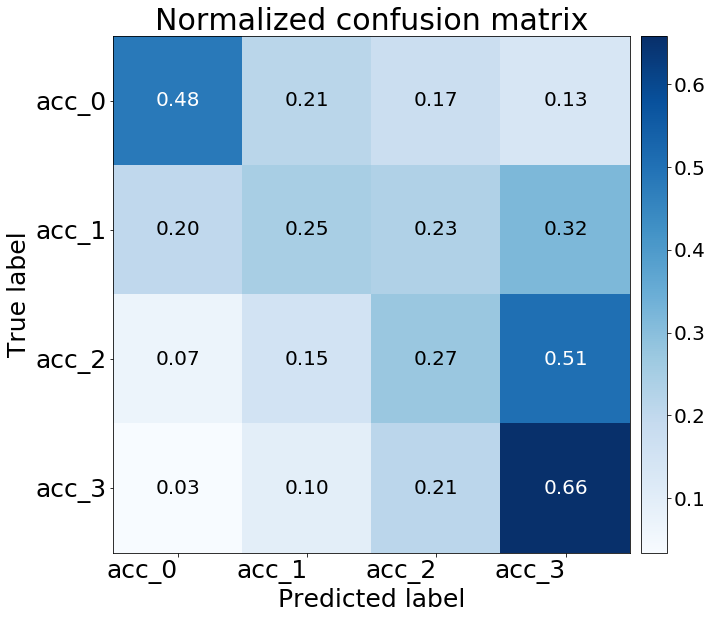

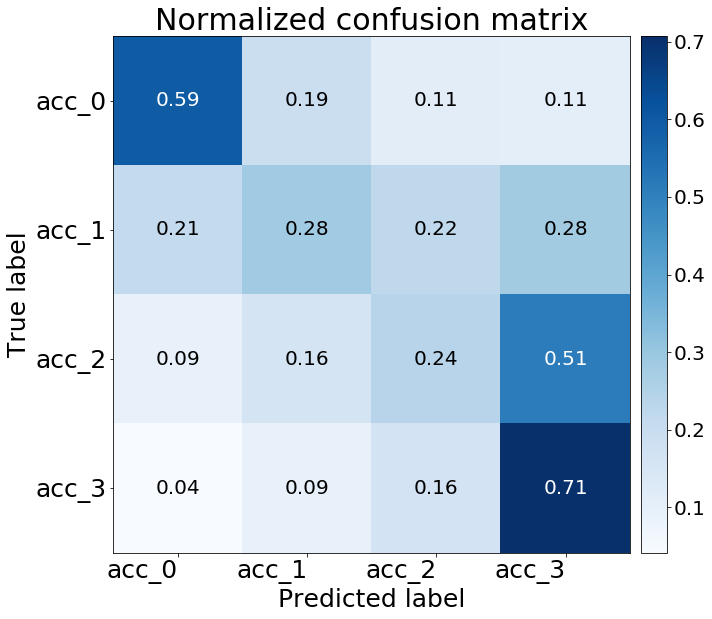

In [49]:
# Confusion Matrix
plot_confusion_matrix(
    y_oof,
    oof_preds_optimized,
    classes=np.array(["acc_0", "acc_1", "acc_2", "acc_3"]),
    normalize=True,
    save_path=output_dir / "confusion_matrix_oof.png")

plot_confusion_matrix(
    y_train,
    avg_normal_oof_optimized,
    classes=np.array(["acc_0", "acc_1", "acc_2", "acc_3"]),
    normalize=True,
    save_path=output_dir / "confusion_matrix_oof.png")

In [50]:
np.save("oof_preds.npy", oof_preds_optimized)
np.save("normal_oof_preds.npy", avg_normal_oof_optimized)

### Make submission

In [51]:
sample_submission = pd.read_csv(
    input_dir / "sample_submission.csv")
sample_submission["accuracy_group"] = test_preds_optimized
sample_submission.to_csv('submission.csv', index=None)
sample_submission.head()

,installation_id,accuracy_group
0,00abaee7,2
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3
